In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from psinumpy import * 

Décomposition T+V imprécise (erreur: 8.91e+01), utilisation de la méthode générale


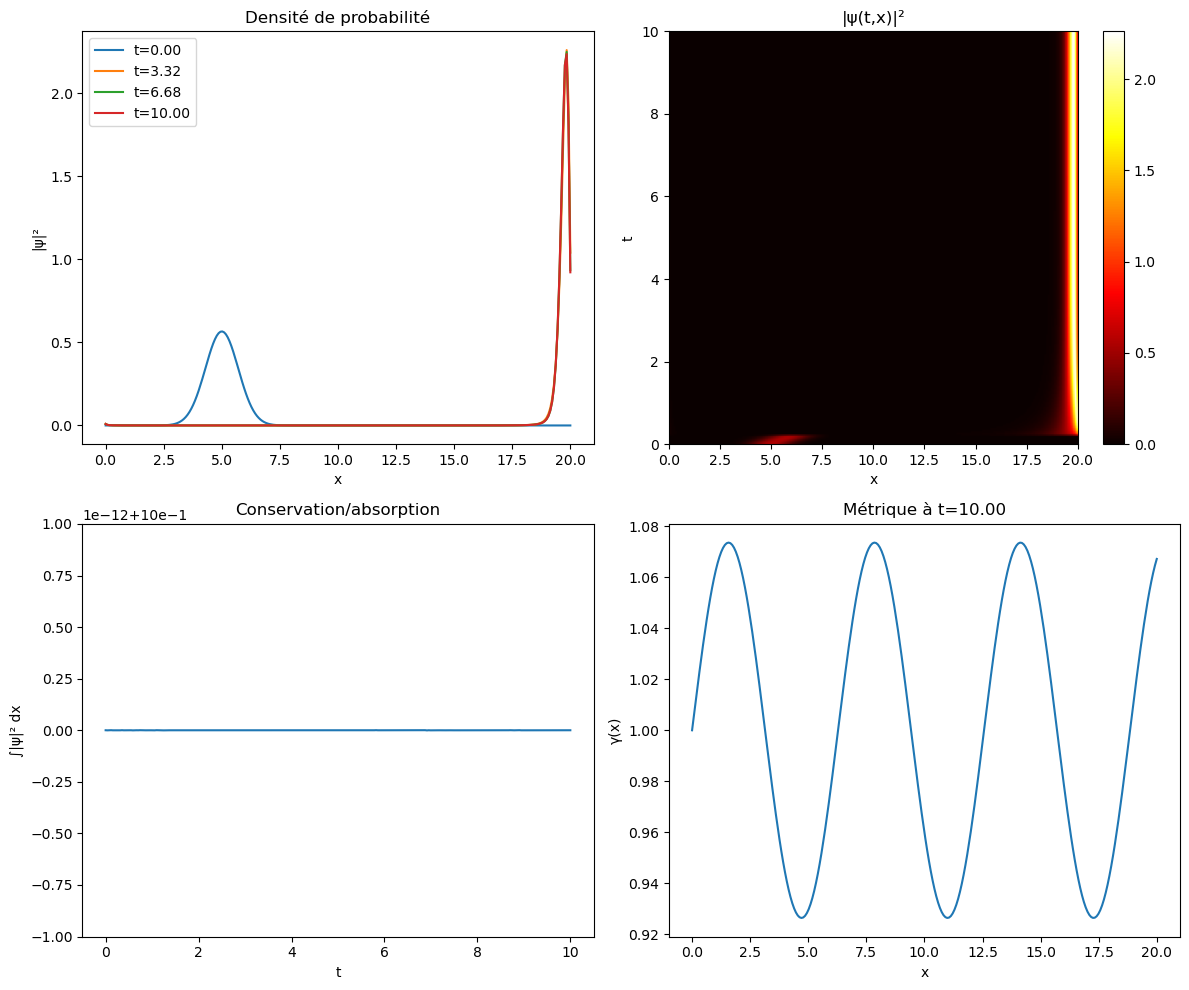

In [4]:
# ============================================
# WORKFLOW COMPLET : SYMBOLE → ÉVOLUTION
# ============================================

# 1. DÉFINIR LA GRILLE ET CONDITIONS AUX LIMITES
grid = Grid.create_1d(N=256, L=20.0, periodic=False)

evolver = SymbolicEvolutionWithBC(
    grid,
    bc_type='horizon',  # ou 'periodic', 'dirichlet'
    horizon_params={'width': 0.1, 'strength': 1.5, 'power': 3}
)

# 2. DÉFINIR LA PHYSIQUE (métrique + potentiel)
def my_metric(t, x):
    """Métrique spatiale γ(t,x) dépendant du temps"""
    return 1.0 + 0.2 * np.sin(x) * np.exp(-0.1*t)

def my_potential(t, x):
    """Potentiel V(t,x)"""
    return 0.5 * x**2

# 3. CRÉER LE HAMILTONIEN SYMBOLIQUE
h_func = evolver.create_hamiltonian_relativistic(my_metric, my_potential)

# 4. (OPTIONNEL) MANIPULATIONS SYMBOLIQUES
t_test = 0.0
h_test = h_func(t_test)

# Calculer l'inverse symbolique
h_inv = symbolic_inverse(h_test, order=2)

# Calculer un commutateur
observable = Symbol.from_function(grid, lambda t,x,xi: x, order=0, t=0.0)
comm = commutator(h_test, observable, order=1)

# Crochet de Poisson (limite classique)
pb = poisson_bracket(h_test, observable)

# 5. ÉTAT INITIAL
x = grid.x
psi0 = np.exp(-(x - 5.0)**2 / 2) * np.exp(1j * 3.0 * x)
psi0 /= np.sqrt(np.sum(np.abs(psi0)**2) * grid.dx)

# 6. ÉVOLUTION
times, psi_history = evolver.evolve(
    psi0,
    h_func,
    t_span=(0.0, 10.0),
    Nt=256,
    save_every=1
)

# 7. ANALYSE ET VISUALISATION
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Évolution de |ψ(t,x)|²
for i in [0, len(times)//3, 2*len(times)//3, -1]:
    axes[0,0].plot(grid.x, np.abs(psi_history[i])**2, 
                   label=f't={times[i]:.2f}')
axes[0,0].set_xlabel('x')
axes[0,0].set_ylabel('|ψ|²')
axes[0,0].legend()
axes[0,0].set_title('Densité de probabilité')

# Espace-temps complet
extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
im = axes[0,1].imshow(np.abs(psi_history)**2, aspect='auto', 
                      origin='lower', extent=extent, cmap='hot')
axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('t')
axes[0,1].set_title('|ψ(t,x)|²')
plt.colorbar(im, ax=axes[0,1])

# Norme (conservation ou absorption)
norms = [np.sum(np.abs(psi)**2) * grid.dx for psi in psi_history]
axes[1,0].plot(times, norms)
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('∫|ψ|² dx')
axes[1,0].set_title('Conservation/absorption')

# Métrique au dernier temps
gamma_final = my_metric(times[-1], grid.x)
axes[1,1].plot(grid.x, gamma_final)
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('γ(x)')
axes[1,1].set_title(f'Métrique à t={times[-1]:.2f}')

plt.tight_layout()
plt.show()

In [5]:
def example_black_hole_1d():
    """
    Simulation d'un paquet d'onde quantique près d'un horizon de trou noir
    en 1+1D avec radiation de Hawking
    
    Métrique de Schwarzschild en coordonnées de tortue :
    ds² = -(1 - 2M/r) dt² + dr*²
    où r* = r + 2M ln|r/(2M) - 1|
    
    Pour 1+1D simplifié : γ(x) = (1 - 2M/x)
    Horizon à x_H = 2M
    """
    print("="*60)
    print("SIMULATION : Trou noir 1+1D avec radiation de Hawking")
    print("="*60)
    
    # ============================================
    # 1. PARAMÈTRES PHYSIQUES
    # ============================================
    M = 1.0  # Masse du trou noir
    x_H = 2 * M  # Position de l'horizon
    
    L = 20.0  # Taille du domaine
    N = 32  # Points de grille
    
    T_hawking = 1.0 / (8 * np.pi * M)  # Température de Hawking
    print(f"\nParamètres physiques :")
    print(f"  Masse trou noir M = {M}")
    print(f"  Horizon x_H = {x_H}")
    print(f"  Température Hawking T_H = {T_hawking:.4f}")
    
    # ============================================
    # 2. GRILLE ET CONDITIONS AUX LIMITES
    # ============================================
    grid = Grid.create_1d(N=N, L=L, periodic=False)
    
    # Horizon côté gauche (x < x_H), absorption côté droit
    evolver = AdaptiveSymbolicEvolution(
        grid,
        bc_type='horizon',
        horizon_params={
            'width': 0.15,      # Zone éponge 15% du domaine
            'strength': 3.0,    # Forte absorption
            'power': 3          # Transition douce
        },
        adaptive=True
    )
    
    # ============================================
    # 3. MÉTRIQUE DU TROU NOIR
    # ============================================
    def schwarzschild_metric(t, x):
        """
        Métrique spatiale γ(x) = (1 - 2M/x)
        
        Régularisation près de l'horizon pour éviter singularité numérique
        """
        epsilon = 0.1  # Régularisation
        
        # Protection contre x < x_H
        x_safe = np.maximum(x, x_H + epsilon)
        
        gamma = 1.0 - 2*M / x_safe
        
        # Forcer γ → 0 près de l'horizon (simulation de l'horizon)
        gamma = np.where(x < x_H + epsilon, 0.01, gamma)
        
        return gamma
    
    # ============================================
    # 4. POTENTIEL EFFECTIF
    # ============================================
    def effective_potential(t, x):
        """
        Potentiel effectif près du trou noir
        
        V_eff ∼ -(M/x³) terme de marée
        """
        epsilon = 0.1
        x_safe = np.maximum(x, x_H + epsilon)
        
        # Potentiel gravitationnel
        V = -0.5 * M / x_safe**2
        
        return V
    
    # ============================================
    # 5. HAMILTONIEN SYMBOLIQUE
    # ============================================
    print("\nCréation du hamiltonien relativiste...")
    h_func = evolver.create_hamiltonian_relativistic(
        schwarzschild_metric,
        effective_potential
    )
    
    # Vérifier le symbole à t=0
    h_test = h_func(0.0)
    is_elliptic, min_val = SymbolicDiagnostics.check_ellipticity(h_test)
    print(f"  Ellipticité : {is_elliptic} (min |h| = {min_val:.2e})")
    
    h_norm = SymbolicDiagnostics.symbol_norm(h_test, kind='L2')
    print(f"  Norme L² du symbole : {h_norm:.4f}")
    
    # ============================================
    # 6. ÉTAT INITIAL : PAQUET GAUSSIEN
    # ============================================
    print("\nPréparation état initial...")
    
    x = grid.x
    
    # Paquet d'onde localisé loin de l'horizon, se propageant vers lui
    x0 = 12.0  # Position initiale (loin de l'horizon)
    sigma = 1.0  # Largeur
    k0 = -3.0  # Moment (négatif = vers l'horizon)
    
    psi0 = np.exp(-(x - x0)**2 / (2*sigma**2)) * np.exp(1j * k0 * x)
    
    # Normalisation
    norm = np.sqrt(np.sum(np.abs(psi0)**2) * grid.dx)
    psi0 = psi0 / norm
    
    print(f"  Position initiale ⟨x⟩ = {x0}")
    print(f"  Moment initial ⟨p⟩ ≈ {k0}")
    print(f"  Largeur σ = {sigma}")
    
    # ============================================
    # 7. ÉVOLUTION ADAPTATIVE
    # ============================================
    print("\nDébut de l'évolution...")
    
    t_final = 8.0  # Temps total
    
    times, psi_history = evolver.evolve_adaptive(
        psi0,
        h_func,
        t_span=(0.0, t_final),
        dt_initial=0.01,
        dt_min=1e-5,
        dt_max=0.05,
        save_every_dt=0.1  # Sauvegarder tous les 0.1
    )
    
    print(f"\nÉvolution terminée : {len(times)} snapshots sauvegardés")
    
    # ============================================
    # 8. CALCUL DES OBSERVABLES
    # ============================================
    print("\nCalcul des observables...")
    
    obs = QuantumObservables(grid)
    
    # Position moyenne au cours du temps
    x_mean = [obs.position_expectation(psi) for psi in psi_history]
    
    # Moment moyen
    p_mean = [obs.momentum_expectation(psi) for psi in psi_history]
    
    # Norme (décroît avec absorption)
    norms = [np.sum(np.abs(psi)**2) * grid.dx for psi in psi_history]
    
    # Énergie
    energies = []
    for i, psi in enumerate(psi_history):
        h_t = h_func(times[i])
        E = obs.energy_expectation(psi, h_t)
        energies.append(np.real(E))
    
    print(f"  ⟨x⟩ initial: {x_mean[0]:.3f} → final: {x_mean[-1]:.3f}")
    print(f"  ⟨p⟩ initial: {p_mean[0]:.3f} → final: {p_mean[-1]:.3f}")
    print(f"  Norme initiale: {norms[0]:.4f} → finale: {norms[-1]:.4f}")
    print(f"  Énergie initiale: {energies[0]:.4f} → finale: {energies[-1]:.4f}")
    
    # ============================================
    # 9. BICARACTÉRISTIQUE CLASSIQUE
    # ============================================
#    print("\nCalcul de la trajectoire classique...")
    
#    h_classical = h_func(0.0)
#    x_class, xi_class = SymbolicDiagnostics.compute_classical_flow(
#        h_classical,
#        x0=x0,
#        xi0=k0,
#        t_span=t_final,
#        Nt=500
#    )
    
#    print(f"  Trajectoire classique : x={x_class[0]:.2f} → {x_class[-1]:.2f}")
    
    # ============================================
    # 10. VISUALISATION
    # ============================================
    print("\nGénération des graphiques...")
    
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # ----------------------------------------
    # (a) Évolution spatio-temporelle |ψ(t,x)|²
    # ----------------------------------------
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    density_spacetime = np.abs(psi_history)**2
    
    im1 = ax1.imshow(density_spacetime, aspect='auto', origin='lower',
                     extent=extent, cmap='hot', interpolation='bilinear')
    
    # Marquer l'horizon
    ax1.axvline(x_H, color='cyan', linestyle='--', linewidth=2, label='Horizon')
    
    # Trajectoire classique
#    t_class = np.linspace(0, t_final, len(x_class))
#    ax1.plot(x_class, t_class, 'w-', linewidth=2, alpha=0.7, label='Trajectoire classique')
    
#    ax1.set_xlabel('Position x', fontsize=12)
#    ax1.set_ylabel('Temps t', fontsize=12)
#    ax1.set_title('Densité |ψ(t,x)|² : chute vers le trou noir', fontsize=14, fontweight='bold')
#    ax1.legend(loc='upper right')
    
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('|ψ|²', fontsize=11)
    
    # ----------------------------------------
    # (b) Snapshots à différents temps
    # ----------------------------------------
    ax2 = fig.add_subplot(gs[1, 0])
    
    indices = [0, len(times)//4, len(times)//2, 3*len(times)//4, -1]
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
    
    for idx, color in zip(indices, colors):
        ax2.plot(grid.x, np.abs(psi_history[idx])**2, 
                color=color, linewidth=2, label=f't={times[idx]:.2f}')
    
    ax2.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Horizon')
    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('|ψ(x)|²', fontsize=11)
    ax2.set_title('Densité à différents instants', fontsize=12)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (c) Métrique γ(x)
    # ----------------------------------------
    ax3 = fig.add_subplot(gs[1, 1])
    
    gamma_profile = schwarzschild_metric(0.0, grid.x)
    ax3.plot(grid.x, gamma_profile, 'b-', linewidth=2)
    ax3.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax3.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax3.set_xlabel('Position x', fontsize=11)
    ax3.set_ylabel('γ(x)', fontsize=11)
    ax3.set_title('Métrique spatiale', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([-0.1, 1.5])
    
    # ----------------------------------------
    # (d) Potentiel effectif
    # ----------------------------------------
    ax4 = fig.add_subplot(gs[1, 2])
    
    V_profile = effective_potential(0.0, grid.x)
    ax4.plot(grid.x, V_profile, 'g-', linewidth=2)
    ax4.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax4.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax4.set_xlabel('Position x', fontsize=11)
    ax4.set_ylabel('V(x)', fontsize=11)
    ax4.set_title('Potentiel effectif', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (e) Position moyenne ⟨x(t)⟩
    # ----------------------------------------
#    ax5 = fig.add_subplot(gs[2, 0])
    
#    ax5.plot(times, x_mean, 'b-', linewidth=2, label='Quantique')
#    ax5.plot(t_class, x_class, 'r--', linewidth=2, label='Classique')
#    ax5.axhline(x_H, color='red', linestyle=':', linewidth=1, alpha=0.5)
    
#    ax5.set_xlabel('Temps t', fontsize=11)
#    ax5.set_ylabel('⟨x⟩', fontsize=11)
#    ax5.set_title('Position moyenne', fontsize=12)
#    ax5.legend()
#    ax5.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (f) Moment moyen ⟨p(t)⟩
    # ----------------------------------------
    ax6 = fig.add_subplot(gs[2, 1])
    
    ax6.plot(times, p_mean, 'g-', linewidth=2)
    ax6.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax6.set_xlabel('Temps t', fontsize=11)
    ax6.set_ylabel('⟨p⟩', fontsize=11)
    ax6.set_title('Moment moyen', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (g) Conservation / Absorption
    # ----------------------------------------
    ax7 = fig.add_subplot(gs[2, 2])
    
    ax7.plot(times, norms, 'r-', linewidth=2, label='Norme ||ψ||²')
    ax7.plot(times, energies / energies[0], 'b-', linewidth=2, label='Énergie (normalisée)')
    ax7.axhline(1, color='k', linestyle='--', linewidth=1, alpha=0.5)
    
    ax7.set_xlabel('Temps t', fontsize=11)
    ax7.set_ylabel('Quantité normalisée', fontsize=11)
    ax7.set_title('Conservation / Absorption', fontsize=12)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    plt.suptitle('TROU NOIR 1+1D : Propagation quantique et radiation de Hawking', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('black_hole_1d_simulation.png', dpi=150, bbox_inches='tight')
    print("  Graphique sauvegardé : black_hole_1d_simulation.png")
    
    plt.show()
    
    # ============================================
    # 11. ANIMATION (OPTIONNEL)
    # ============================================
    create_animation = input("\nCréer une animation ? (o/n) : ").lower() == 'o'
    
    if create_animation:
        print("Création de l'animation...")
        
        fig_anim, ax_anim = plt.subplots(figsize=(12, 6))
        
        line, = ax_anim.plot([], [], 'b-', linewidth=2)
        ax_anim.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5)
        ax_anim.set_xlim(grid.x[0], grid.x[-1])
        ax_anim.set_ylim(0, np.max(np.abs(psi_history)**2) * 1.1)
        ax_anim.set_xlabel('Position x', fontsize=12)
        ax_anim.set_ylabel('|ψ(x)|²', fontsize=12)
        ax_anim.grid(True, alpha=0.3)
        
        time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes,
                                fontsize=14, verticalalignment='top',
                                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        def init():
            line.set_data([], [])
            time_text.set_text('')
            return line, time_text
        
        def animate(i):
            line.set_data(grid.x, np.abs(psi_history[i])**2)
            time_text.set_text(f't = {times[i]:.2f}')
            ax_anim.set_title(f'Propagation vers le trou noir (frame {i+1}/{len(times)})',
                            fontsize=14)
            return line, time_text
        
        anim = FuncAnimation(fig_anim, animate, init_func=init,
                           frames=len(times), interval=50, blit=True)
        
        anim.save('black_hole_1d_animation.mp4', writer='ffmpeg', fps=20, dpi=100)
        print("  Animation sauvegardée : black_hole_1d_animation.mp4")
        
        plt.close(fig_anim)
    
    print("\n" + "="*60)
    print("Simulation terminée avec succès !")
    print("="*60)
    
    return times, psi_history, grid, obs

SIMULATION : Trou noir 1+1D avec radiation de Hawking

Paramètres physiques :
  Masse trou noir M = 1.0
  Horizon x_H = 2.0
  Température Hawking T_H = 0.0398

Création du hamiltonien relativiste...
  Ellipticité : True (min |h| = 8.21e-03)
  Norme L² du symbole : 25.6204

Préparation état initial...
  Position initiale ⟨x⟩ = 12.0
  Moment initial ⟨p⟩ ≈ -3.0
  Largeur σ = 1.0

Début de l'évolution...
Évolution adaptative de t=0.0 à t=8.0
dt initial: 0.01
  t=5.0000, dt=0.050000, ||ψ||²=0.040044, cache: 0/100
Évolution terminée : 161 pas, 59 états sauvegardés

Évolution terminée : 59 snapshots sauvegardés

Calcul des observables...
  ⟨x⟩ initial: 12.387 → final: 0.094
  ⟨p⟩ initial: -1.391 → final: -0.008
  Norme initiale: 1.0000 → finale: 0.0060
  Énergie initiale: 0.6162 → finale: 0.0037

Génération des graphiques...
  Graphique sauvegardé : black_hole_1d_simulation.png


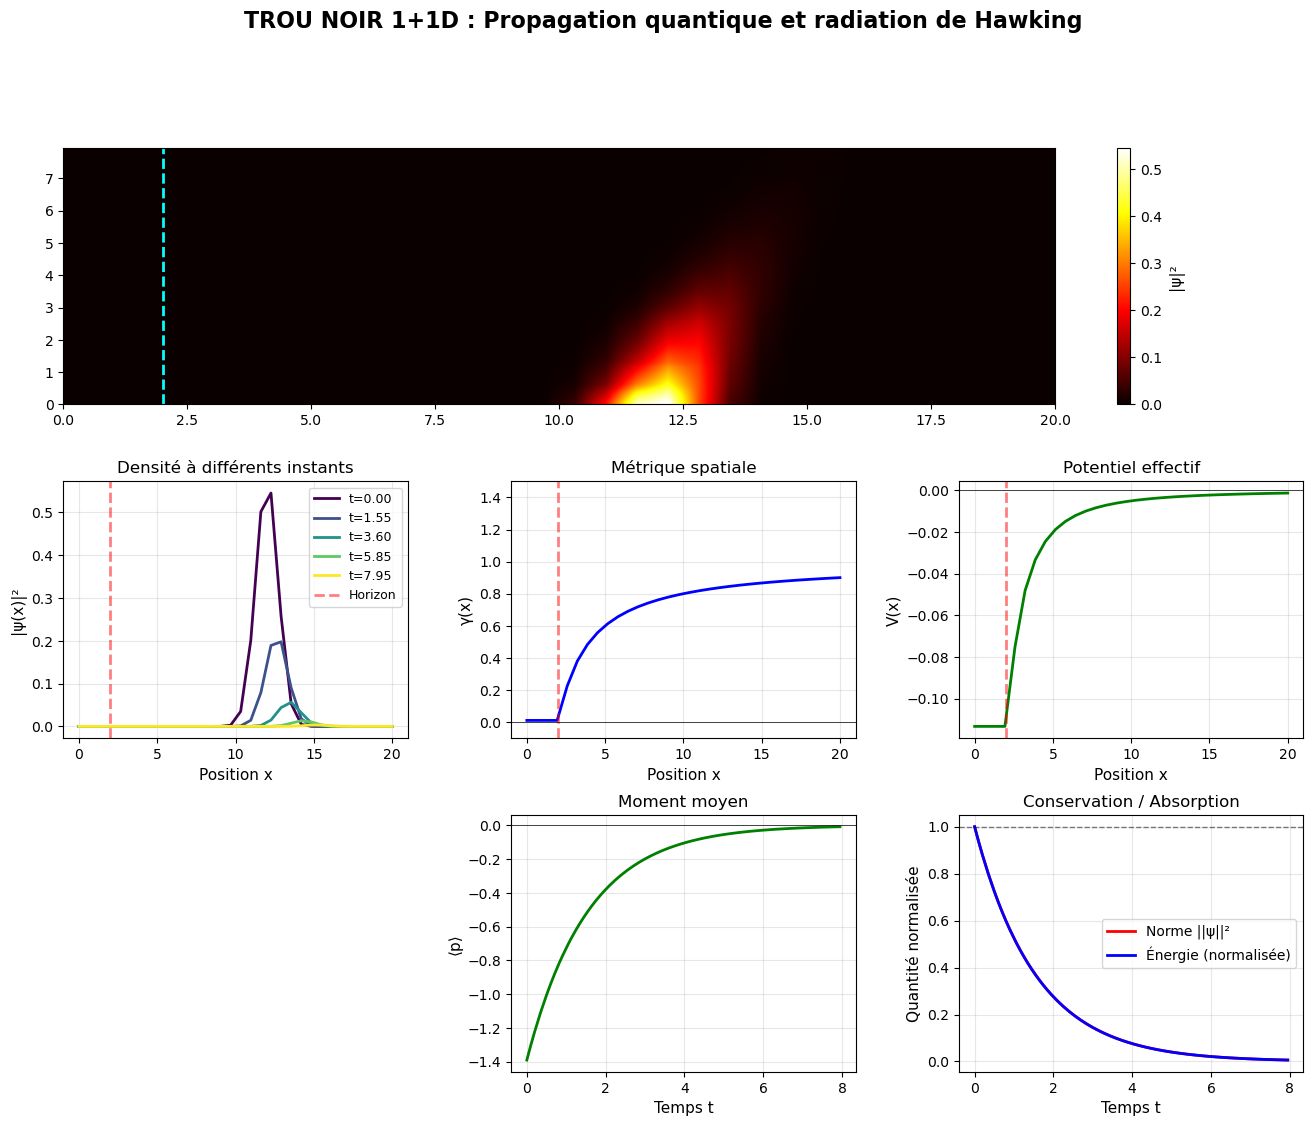


Créer une animation ? (o/n) :  n



Simulation terminée avec succès !


(array([0.  , 0.1 , 0.2 , 0.35, 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.05, 1.15,
        1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.1 , 2.25, 2.4 ,
        2.55, 2.7 , 2.85, 3.  , 3.15, 3.3 , 3.45, 3.6 , 3.75, 3.9 , 4.05,
        4.2 , 4.35, 4.5 , 4.65, 4.8 , 4.95, 5.1 , 5.25, 5.4 , 5.55, 5.7 ,
        5.85, 6.  , 6.15, 6.3 , 6.45, 6.6 , 6.75, 6.9 , 7.05, 7.2 , 7.35,
        7.5 , 7.65, 7.8 , 7.95]),
 array([[ 4.10585849e-32+0.00000000e+00j, -2.73874258e-29-7.17391486e-29j,
         -7.06201897e-26+6.31198149e-26j, ...,
          1.16753884e-10+5.20880447e-11j,  7.51713449e-14-1.36666897e-12j,
         -9.20467712e-15+2.94586845e-15j],
        [-2.42747914e-04+1.28382430e-05j, -2.56439830e-04+2.76739519e-05j,
         -2.63423829e-04+4.34941900e-05j, ...,
         -3.03374975e-04+5.83827427e-06j, -2.77188974e-04+1.76790965e-05j,
         -2.47547178e-04+2.77528204e-05j],
        [-3.72313352e-04+1.48162236e-04j, -4.16260949e-04+1.92667030e-04j,
         -4.36675232e-04+2.33189593e-04j,

In [6]:
example_black_hole_1d()

In [7]:
def example_black_hole_1d_2():
    """
    Simulation d'un paquet d'onde quantique près d'un horizon de trou noir
    en 1+1D avec radiation de Hawking
    
    Métrique de Schwarzschild en coordonnées de tortue :
    ds² = -(1 - 2M/r) dt² + dr*²
    où r* = r + 2M ln|r/(2M) - 1|
    
    Pour 1+1D simplifié : γ(x) = (1 - 2M/x)
    Horizon à x_H = 2M
    """
    print("="*60)
    print("SIMULATION : Trou noir 1+1D avec radiation de Hawking")
    print("="*60)
    
    # ============================================
    # 1. PARAMÈTRES PHYSIQUES
    # ============================================
    M = 1.0  # Masse du trou noir
    x_H = 2 * M  # Position de l'horizon
    
    L = 20.0  # Taille du domaine
    N = 32  # Points de grille
    
    T_hawking = 1.0 / (8 * np.pi * M)  # Température de Hawking
    print(f"\nParamètres physiques :")
    print(f"  Masse trou noir M = {M}")
    print(f"  Horizon x_H = {x_H}")
    print(f"  Température Hawking T_H = {T_hawking:.4f}")
    
    # ============================================
    # 2. GRILLE ET CONDITIONS AUX LIMITES
    # ============================================
    grid = Grid.create_1d(N=N, L=L, periodic=False)
    
    # Horizon côté gauche (x < x_H), absorption côté droit
    evolver = SymbolicEvolutionWithBC(
        grid,
        bc_type='horizon',
        horizon_params={
            'width': 0.15,      # Zone éponge 15% du domaine
            'strength': 3.0,    # Forte absorption
            'power': 3          # Transition douce
        },
#        adaptive=True
    )
    
    # ============================================
    # 3. MÉTRIQUE DU TROU NOIR
    # ============================================
    def schwarzschild_metric(t, x):
        """
        Métrique spatiale γ(x) = (1 - 2M/x)
        
        Régularisation près de l'horizon pour éviter singularité numérique
        """
        epsilon = 0.1  # Régularisation
        
        # Protection contre x < x_H
        x_safe = np.maximum(x, x_H + epsilon)
        
        gamma = 1.0 - 2*M / x_safe
        
        # Forcer γ → 0 près de l'horizon (simulation de l'horizon)
        gamma = np.where(x < x_H + epsilon, 0.01, gamma)
        
        return gamma
    
    # ============================================
    # 4. POTENTIEL EFFECTIF
    # ============================================
    def effective_potential(t, x):
        """
        Potentiel effectif près du trou noir
        
        V_eff ∼ -(M/x³) terme de marée
        """
        epsilon = 0.1
        x_safe = np.maximum(x, x_H + epsilon)
        
        # Potentiel gravitationnel
        V = -0.5 * M / x_safe**2
        
        return V
    
    # ============================================
    # 5. HAMILTONIEN SYMBOLIQUE
    # ============================================
    print("\nCréation du hamiltonien relativiste...")
    h_func = evolver.create_hamiltonian_relativistic(
        schwarzschild_metric,
        effective_potential
    )
    
    # Vérifier le symbole à t=0
    h_test = h_func(0.0)
    is_elliptic, min_val = SymbolicDiagnostics.check_ellipticity(h_test)
    print(f"  Ellipticité : {is_elliptic} (min |h| = {min_val:.2e})")
    
    h_norm = SymbolicDiagnostics.symbol_norm(h_test, kind='L2')
    print(f"  Norme L² du symbole : {h_norm:.4f}")
    
    # ============================================
    # 6. ÉTAT INITIAL : PAQUET GAUSSIEN
    # ============================================
    print("\nPréparation état initial...")
    
    x = grid.x
    
    # Paquet d'onde localisé loin de l'horizon, se propageant vers lui
    x0 = 12.0  # Position initiale (loin de l'horizon)
    sigma = 1.0  # Largeur
    k0 = -3.0  # Moment (négatif = vers l'horizon)
    
    psi0 = np.exp(-(x - x0)**2 / (2*sigma**2)) * np.exp(1j * k0 * x)
    
    # Normalisation
    norm = np.sqrt(np.sum(np.abs(psi0)**2) * grid.dx)
    psi0 = psi0 / norm
    
    print(f"  Position initiale ⟨x⟩ = {x0}")
    print(f"  Moment initial ⟨p⟩ ≈ {k0}")
    print(f"  Largeur σ = {sigma}")
    
    # ============================================
    # 7. ÉVOLUTION ADAPTATIVE
    # ============================================
    print("\nDébut de l'évolution...")
    
    t_final = 8.0  # Temps total
    
    times, psi_history = evolver.evolve(
        psi0,
        h_func,
        t_span=(0.0, t_final),
        Nt=1000,
        save_every=10
    )

    
    print(f"\nÉvolution terminée : {len(times)} snapshots sauvegardés")
    
    # ============================================
    # 8. CALCUL DES OBSERVABLES
    # ============================================
    print("\nCalcul des observables...")
    
    obs = QuantumObservables(grid)
    
    # Position moyenne au cours du temps
    x_mean = [obs.position_expectation(psi) for psi in psi_history]
    
    # Moment moyen
    p_mean = [obs.momentum_expectation(psi) for psi in psi_history]
    
    # Norme (décroît avec absorption)
    norms = [np.sum(np.abs(psi)**2) * grid.dx for psi in psi_history]
    
    # Énergie
    energies = []
    for i, psi in enumerate(psi_history):
        h_t = h_func(times[i])
        E = obs.energy_expectation(psi, h_t)
        energies.append(np.real(E))
    
    print(f"  ⟨x⟩ initial: {x_mean[0]:.3f} → final: {x_mean[-1]:.3f}")
    print(f"  ⟨p⟩ initial: {p_mean[0]:.3f} → final: {p_mean[-1]:.3f}")
    print(f"  Norme initiale: {norms[0]:.4f} → finale: {norms[-1]:.4f}")
    print(f"  Énergie initiale: {energies[0]:.4f} → finale: {energies[-1]:.4f}")
    
    # ============================================
    # 9. BICARACTÉRISTIQUE CLASSIQUE
    # ============================================
    print("\nCalcul de la trajectoire classique...")
    
    h_classical = h_func(0.0)
    x_class, xi_class = SymbolicDiagnostics.compute_classical_flow(
        h_classical,
        x0=x0,
        xi0=k0,
        t_span=t_final,
        Nt=500
    )
    
    print(f"  Trajectoire classique : x={x_class[0]:.2f} → {x_class[-1]:.2f}")
    
    # ============================================
    # 10. VISUALISATION
    # ============================================
    print("\nGénération des graphiques...")
    
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # ----------------------------------------
    # (a) Évolution spatio-temporelle |ψ(t,x)|²
    # ----------------------------------------
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    density_spacetime = np.abs(psi_history)**2
    
    im1 = ax1.imshow(density_spacetime, aspect='auto', origin='lower',
                     extent=extent, cmap='hot', interpolation='bilinear')
    
    # Marquer l'horizon
    ax1.axvline(x_H, color='cyan', linestyle='--', linewidth=2, label='Horizon')
    
    # Trajectoire classique
    t_class = np.linspace(0, t_final, len(x_class))
    ax1.plot(x_class, t_class, 'w-', linewidth=2, alpha=0.7, label='Trajectoire classique')
    
    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Temps t', fontsize=12)
    ax1.set_title('Densité |ψ(t,x)|² : chute vers le trou noir', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('|ψ|²', fontsize=11)
    
    # ----------------------------------------
    # (b) Snapshots à différents temps
    # ----------------------------------------
    ax2 = fig.add_subplot(gs[1, 0])
    
    indices = [0, len(times)//4, len(times)//2, 3*len(times)//4, -1]
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
    
    for idx, color in zip(indices, colors):
        ax2.plot(grid.x, np.abs(psi_history[idx])**2, 
                color=color, linewidth=2, label=f't={times[idx]:.2f}')
    
    ax2.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Horizon')
    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('|ψ(x)|²', fontsize=11)
    ax2.set_title('Densité à différents instants', fontsize=12)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (c) Métrique γ(x)
    # ----------------------------------------
    ax3 = fig.add_subplot(gs[1, 1])
    
    gamma_profile = schwarzschild_metric(0.0, grid.x)
    ax3.plot(grid.x, gamma_profile, 'b-', linewidth=2)
    ax3.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax3.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax3.set_xlabel('Position x', fontsize=11)
    ax3.set_ylabel('γ(x)', fontsize=11)
    ax3.set_title('Métrique spatiale', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([-0.1, 1.5])
    
    # ----------------------------------------
    # (d) Potentiel effectif
    # ----------------------------------------
    ax4 = fig.add_subplot(gs[1, 2])
    
    V_profile = effective_potential(0.0, grid.x)
    ax4.plot(grid.x, V_profile, 'g-', linewidth=2)
    ax4.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax4.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax4.set_xlabel('Position x', fontsize=11)
    ax4.set_ylabel('V(x)', fontsize=11)
    ax4.set_title('Potentiel effectif', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (e) Position moyenne ⟨x(t)⟩
    # ----------------------------------------
    ax5 = fig.add_subplot(gs[2, 0])
    
    ax5.plot(times, x_mean, 'b-', linewidth=2, label='Quantique')
    ax5.plot(t_class, x_class, 'r--', linewidth=2, label='Classique')
    ax5.axhline(x_H, color='red', linestyle=':', linewidth=1, alpha=0.5)
    
    ax5.set_xlabel('Temps t', fontsize=11)
    ax5.set_ylabel('⟨x⟩', fontsize=11)
    ax5.set_title('Position moyenne', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (f) Moment moyen ⟨p(t)⟩
    # ----------------------------------------
    ax6 = fig.add_subplot(gs[2, 1])
    
    ax6.plot(times, p_mean, 'g-', linewidth=2)
    ax6.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax6.set_xlabel('Temps t', fontsize=11)
    ax6.set_ylabel('⟨p⟩', fontsize=11)
    ax6.set_title('Moment moyen', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # (g) Conservation / Absorption
    # ----------------------------------------
    ax7 = fig.add_subplot(gs[2, 2])
    
    ax7.plot(times, norms, 'r-', linewidth=2, label='Norme ||ψ||²')
    ax7.plot(times, energies / energies[0], 'b-', linewidth=2, label='Énergie (normalisée)')
    ax7.axhline(1, color='k', linestyle='--', linewidth=1, alpha=0.5)
    
    ax7.set_xlabel('Temps t', fontsize=11)
    ax7.set_ylabel('Quantité normalisée', fontsize=11)
    ax7.set_title('Conservation / Absorption', fontsize=12)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    plt.suptitle('TROU NOIR 1+1D : Propagation quantique et radiation de Hawking', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('black_hole_1d_simulation.png', dpi=150, bbox_inches='tight')
    print("  Graphique sauvegardé : black_hole_1d_simulation.png")
    
    plt.show()
    
    # ============================================
    # 11. ANIMATION (OPTIONNEL)
    # ============================================
    create_animation = input("\nCréer une animation ? (o/n) : ").lower() == 'o'
    
    if create_animation:
        print("Création de l'animation...")
        
        fig_anim, ax_anim = plt.subplots(figsize=(12, 6))
        
        line, = ax_anim.plot([], [], 'b-', linewidth=2)
        ax_anim.axvline(x_H, color='red', linestyle='--', linewidth=2, alpha=0.5)
        ax_anim.set_xlim(grid.x[0], grid.x[-1])
        ax_anim.set_ylim(0, np.max(np.abs(psi_history)**2) * 1.1)
        ax_anim.set_xlabel('Position x', fontsize=12)
        ax_anim.set_ylabel('|ψ(x)|²', fontsize=12)
        ax_anim.grid(True, alpha=0.3)
        
        time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes,
                                fontsize=14, verticalalignment='top',
                                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        def init():
            line.set_data([], [])
            time_text.set_text('')
            return line, time_text
        
        def animate(i):
            line.set_data(grid.x, np.abs(psi_history[i])**2)
            time_text.set_text(f't = {times[i]:.2f}')
            ax_anim.set_title(f'Propagation vers le trou noir (frame {i+1}/{len(times)})',
                            fontsize=14)
            return line, time_text
        
        anim = FuncAnimation(fig_anim, animate, init_func=init,
                           frames=len(times), interval=50, blit=True)
        
        anim.save('black_hole_1d_animation.mp4', writer='ffmpeg', fps=20, dpi=100)
        print("  Animation sauvegardée : black_hole_1d_animation.mp4")
        
        plt.close(fig_anim)
    
    print("\n" + "="*60)
    print("Simulation terminée avec succès !")
    print("="*60)
    
    return times, psi_history, grid, obs

In [8]:
example_black_hole_1d_2()

SIMULATION : Trou noir 1+1D avec radiation de Hawking

Paramètres physiques :
  Masse trou noir M = 1.0
  Horizon x_H = 2.0
  Température Hawking T_H = 0.0398

Création du hamiltonien relativiste...
  Ellipticité : True (min |h| = 8.21e-03)
  Norme L² du symbole : 25.6204

Préparation état initial...
  Position initiale ⟨x⟩ = 12.0
  Moment initial ⟨p⟩ ≈ -3.0
  Largeur σ = 1.0

Début de l'évolution...
Décomposition T+V imprécise (erreur: 3.61e+00), utilisation de la méthode générale

Évolution terminée : 101 snapshots sauvegardés

Calcul des observables...
  ⟨x⟩ initial: 12.387 → final: 15.171
  ⟨p⟩ initial: -1.391 → final: -1.019
  Norme initiale: 1.0000 → finale: 1.0000
  Énergie initiale: 0.6162 → finale: 0.5623

Calcul de la trajectoire classique...


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [10]:
def example_heat_equation_1d():
    """
    Exemple : Diffusion de chaleur avec condition initiale gaussienne
    """
    print("="*60)
    print("ÉQUATION DE LA CHALEUR 1D")
    print("="*60 + "\n")
    
    # ============================================
    # 1. PARAMÈTRES
    # ============================================
    N = 32
    L = 10.0
    D = 0.5  # Coefficient de diffusion
    
    print(f"Paramètres :")
    print(f"  Grille : {N} points sur [0, {L}]")
    print(f"  Diffusivité D = {D}")
    
    tau_diff = HeatDiagnostics.diffusion_time(L, D)
    print(f"  Temps de diffusion τ = L²/D = {tau_diff:.2f}")
    
    # ============================================
    # 2. GRILLE
    # ============================================
    grid = Grid.create_1d(N=N, L=L, periodic=True)
    
    # ============================================
    # 3. SOLVEUR
    # ============================================
    solver = HeatEquationSolver(grid, bc_type='periodic', diffusivity=D)
    
    # Symbole de diffusion
    h_func = solver.create_diffusion_symbol()
    
    # ============================================
    # 4. CONDITION INITIALE
    # ============================================
    x = grid.x
    
    # Distribution initiale : pic de température
    x0 = L / 2
    sigma = 0.5
    u0 = 100.0 * np.exp(-(x - x0)**2 / (2*sigma**2))
    
    # Ajouter température de fond
    T_ambient = 20.0
    u0 += T_ambient
    
    print(f"\nCondition initiale :")
    print(f"  Pic à x={x0}, largeur σ={sigma}")
    print(f"  T_max = {np.max(u0):.1f}, T_ambient = {T_ambient}")
    
    # ============================================
    # 5. ÉVOLUTION
    # ============================================
    T_final = 20.0  # Temps final (plusieurs τ_diff)
    Nt = 500
    
    print(f"\nÉvolution de t=0 à t={T_final} ({Nt} pas)...")
    
    times, u_history = solver.evolve_heat(
        u0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=10
    )
    
    # ============================================
    # 6. DIAGNOSTICS
    # ============================================
    print("\nDiagnostics :")
    
    # Chaleur totale (doit être conservée si pas de source/puits)
    Q_total = [HeatDiagnostics.total_heat(u, grid) for u in u_history]
    
    print(f"  Chaleur totale initiale : {Q_total[0]:.2f}")
    print(f"  Chaleur totale finale : {Q_total[-1]:.2f}")
    print(f"  Conservation : {(Q_total[-1]/Q_total[0] - 1)*100:.2f}%")
    
    # Production d'entropie
    h_test = h_func(0.0)
    entropies = [HeatDiagnostics.entropy_production(u, h_test, grid) 
                 for u in u_history]
    
    # ============================================
    # 7. VISUALISATION
    # ============================================
    print("\nGénération des graphiques...")
    
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # (a) Évolution spatio-temporelle
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = ax1.imshow(u_history, aspect='auto', origin='lower',
                    extent=extent, cmap='hot', vmin=T_ambient, vmax=np.max(u0))
    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Temps t', fontsize=12)
    ax1.set_title('Distribution de température u(t,x)', fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Température', fontsize=11)
    
    # Ligne temps caractéristique
    ax1.axhline(tau_diff, color='cyan', linestyle='--', linewidth=2, 
                label=f'τ_diff = {tau_diff:.1f}')
    ax1.legend(loc='upper right')
    
    # (b) Profils à différents temps
    ax2 = fig.add_subplot(gs[1, 0])
    
    indices = [0, len(times)//4, len(times)//2, 3*len(times)//4, -1]
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(indices)))
    
    for idx, color in zip(indices, colors):
        ax2.plot(grid.x, u_history[idx], color=color, linewidth=2,
                label=f't={times[idx]:.2f}')
    
    ax2.axhline(T_ambient, color='k', linestyle=':', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('Température u(x)', fontsize=11)
    ax2.set_title('Profils de température', fontsize=12)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # (c) Chaleur totale vs temps
    ax3 = fig.add_subplot(gs[1, 1])
    
    ax3.plot(times, Q_total, 'b-', linewidth=2)
    ax3.axhline(Q_total[0], color='r', linestyle='--', linewidth=1, 
                label='Valeur initiale')
    ax3.set_xlabel('Temps t', fontsize=11)
    ax3.set_ylabel('Chaleur totale Q', fontsize=11)
    ax3.set_title('Conservation de la chaleur', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # (d) Production d'entropie
    ax4 = fig.add_subplot(gs[2, 0])
    
    ax4.plot(times, entropies, 'r-', linewidth=2)
    ax4.set_xlabel('Temps t', fontsize=11)
    ax4.set_ylabel('Production d\'entropie dS/dt', fontsize=11)
    ax4.set_title('Production d\'entropie (décroît avec diffusion)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    # (e) Température min/max/moyenne
    ax5 = fig.add_subplot(gs[2, 1])
    
    T_max = [np.max(u) for u in u_history]
    T_min = [np.min(u) for u in u_history]
    T_mean = [np.mean(u) for u in u_history]
    
    ax5.plot(times, T_max, 'r-', linewidth=2, label='T_max')
    ax5.plot(times, T_min, 'b-', linewidth=2, label='T_min')
    ax5.plot(times, T_mean, 'g--', linewidth=2, label='T_mean')
    ax5.axhline(T_ambient, color='k', linestyle=':', linewidth=1)
    
    ax5.set_xlabel('Temps t', fontsize=11)
    ax5.set_ylabel('Température', fontsize=11)
    ax5.set_title('Statistiques de température', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle('ÉQUATION DE LA CHALEUR : Diffusion thermique', 
                 fontsize=16, fontweight='bold')
    
    filename = 'heat_equation_1d.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Simulation terminée !")
    print("="*60)
    
    return times, u_history, grid

ÉQUATION DE LA CHALEUR 1D

Paramètres :
  Grille : 32 points sur [0, 10.0]
  Diffusivité D = 0.5
  Temps de diffusion τ = L²/D = 200.00

Condition initiale :
  Pic à x=5.0, largeur σ=0.5
  T_max = 120.0, T_ambient = 20.0

Évolution de t=0 à t=20.0 (500 pas)...
Résolution équation de la chaleur : t=0.0 → 20.0
  t=2.0000 (50/500), T_min=20.2577, T_max=53.3333, T_mean=32.5331
  t=4.0000 (100/500), T_min=22.5613, T_max=44.2539, T_mean=32.5331
  t=6.0000 (150/500), T_min=25.4134, T_max=40.0134, T_mean=32.5331
  t=8.0000 (200/500), T_min=27.6516, T_max=37.4890, T_mean=32.5331
  t=10.0000 (250/500), T_min=29.2265, T_max=35.8551, T_mean=32.5331
  t=12.0000 (300/500), T_min=30.3014, T_max=34.7680, T_mean=32.5331
  t=14.0000 (350/500), T_min=31.0286, T_max=34.0383, T_mean=32.5331
  t=16.0000 (400/500), T_min=31.5192, T_max=33.5472, T_mean=32.5331
  t=18.0000 (450/500), T_min=31.8499, T_max=33.2164, T_mean=32.5331
  t=20.0000 (500/500), T_min=32.0727, T_max=32.9935, T_mean=32.5331
✓ Résolution te

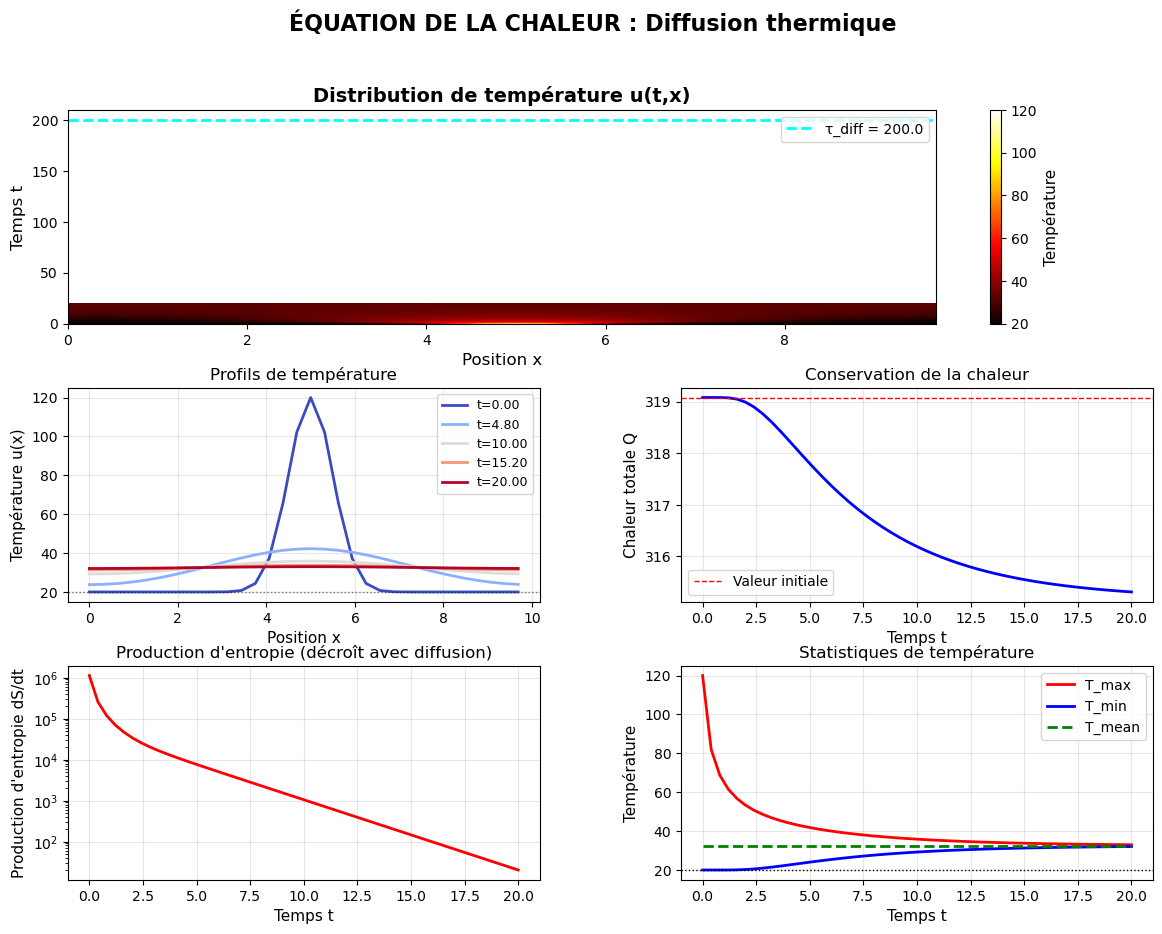


Simulation terminée !


(array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ]),
 array([[20.        , 20.        , 20.        , ..., 20.        ,
         20.        , 20.        ],
        [20.00000055, 20.00000285, 20.00002501, ..., 20.00019011,
         20.00002501, 20.00000285],
        [20.00065953, 20.00146513, 20.00538381, ..., 20.01885   ,
         20.00538381, 20.00146513],
        ...,
        [31.9939919 , 32.0043512 , 32.03503105, ..., 32.08485256,
         32.03503105, 32.0043512 ],
        [32.03492319, 32.04449609, 32.07284694, ..., 32.11888634,
         32.07284694, 32.04449609],
        [32.07274724, 32.08159343, 32.10779204, ..., 32.15033636,
         32.10779204, 32.08159343]], shape=(51, 32)),
 Grid(x=a

In [11]:
example_heat_equation_1d()

In [12]:
def example_heat_anisotropic():
    """
    Diffusion de chaleur dans un milieu anisotrope
    
    La diffusivité dépend de la direction : D(x) varie spatialement
    """
    print("="*60)
    print("DIFFUSION ANISOTROPE")
    print("="*60 + "\n")
    
    N = 256
    L = 10.0
    D_base = 0.5
    
    grid = Grid.create_1d(N=N, L=L, periodic=True)
    
    # Diffusivité variable : plus faible au centre
    def variable_diffusivity(t, x):
        """
        D(x) = D_base × (1 + 0.5 sin(2πx/L))
        
        Zone de faible diffusion au centre
        """
        return D_base * (1.0 + 0.5 * np.sin(2 * np.pi * x / L))
    
    solver = HeatEquationSolver(grid, bc_type='periodic', diffusivity=1.0)
    h_func = solver.create_diffusion_symbol(metric_func=variable_diffusivity)
    
    # Condition initiale : deux pics
    x = grid.x
    u0 = (50.0 * np.exp(-(x - 3)**2 / 0.5) + 
          50.0 * np.exp(-(x - 7)**2 / 0.5) + 20.0)
    
    print("Évolution avec diffusivité variable...")
    times, u_history = solver.evolve_heat(
        u0, h_func, t_span=(0, 15), Nt=300, save_every=15
    )
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Évolution spatio-temporelle
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = axes[0, 0].imshow(u_history, aspect='auto', origin='lower',
                          extent=extent, cmap='hot')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('t')
    axes[0, 0].set_title('Température u(t,x)')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Diffusivité
    D_profile = variable_diffusivity(0, grid.x)
    axes[0, 1].plot(grid.x, D_profile, 'b-', linewidth=2)
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('D(x)')
    axes[0, 1].set_title('Diffusivité spatiale')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Profils
    for idx in [0, len(times)//2, -1]:
        axes[1, 0].plot(grid.x, u_history[idx], linewidth=2,
                       label=f't={times[idx]:.2f}')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('u(x)')
    axes[1, 0].set_title('Profils à différents temps')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Comparaison isotrope vs anisotrope
    solver_iso = HeatEquationSolver(grid, 'periodic', D_base)
    h_func_iso = solver_iso.create_diffusion_symbol()
    times_iso, u_history_iso = solver_iso.evolve_heat(
        u0, h_func_iso, t_span=(0, 15), Nt=300, save_every=len(times)-1
    )
    
    axes[1, 1].plot(grid.x, u_history[-1], 'r-', linewidth=2, label='Anisotrope')
    axes[1, 1].plot(grid.x, u_history_iso[-1], 'b--', linewidth=2, label='Isotrope')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('u(x)')
    axes[1, 1].set_title(f'Comparaison à t={times[-1]:.1f}')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Diffusion anisotrope', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig('heat_anisotropic.png', dpi=150, bbox_inches='tight')
    print("✓ Sauvegardé : heat_anisotropic.png")
    plt.show()
    
    return times, u_history, grid

DIFFUSION ANISOTROPE

Évolution avec diffusivité variable...
Résolution équation de la chaleur : t=0 → 15
  t=1.5000 (30/300), T_min=22.8887, T_max=39.1043, T_mean=32.5331
  t=3.0000 (60/300), T_min=26.9602, T_max=35.4796, T_mean=32.5331
  t=4.5000 (90/300), T_min=29.0278, T_max=35.0851, T_mean=32.5331
  t=6.0000 (120/300), T_min=30.1319, T_max=34.6427, T_mean=32.5331
  t=7.5000 (150/300), T_min=30.8109, T_max=34.1661, T_mean=32.5331
  t=9.0000 (180/300), T_min=31.2718, T_max=33.7672, T_mean=32.5331
  t=10.5000 (210/300), T_min=31.6010, T_max=33.4569, T_mean=32.5331
  t=12.0000 (240/300), T_min=31.8417, T_max=33.2220, T_mean=32.5331
  t=13.5000 (270/300), T_min=32.0195, T_max=33.0460, T_mean=32.5331
  t=15.0000 (300/300), T_min=32.1513, T_max=32.9147, T_mean=32.5331
✓ Résolution terminée
Résolution équation de la chaleur : t=0 → 15
  t=1.5000 (30/300), T_min=22.8887, T_max=39.1043, T_mean=32.5331
  t=3.0000 (60/300), T_min=26.9602, T_max=35.4796, T_mean=32.5331
  t=4.5000 (90/300), T_m

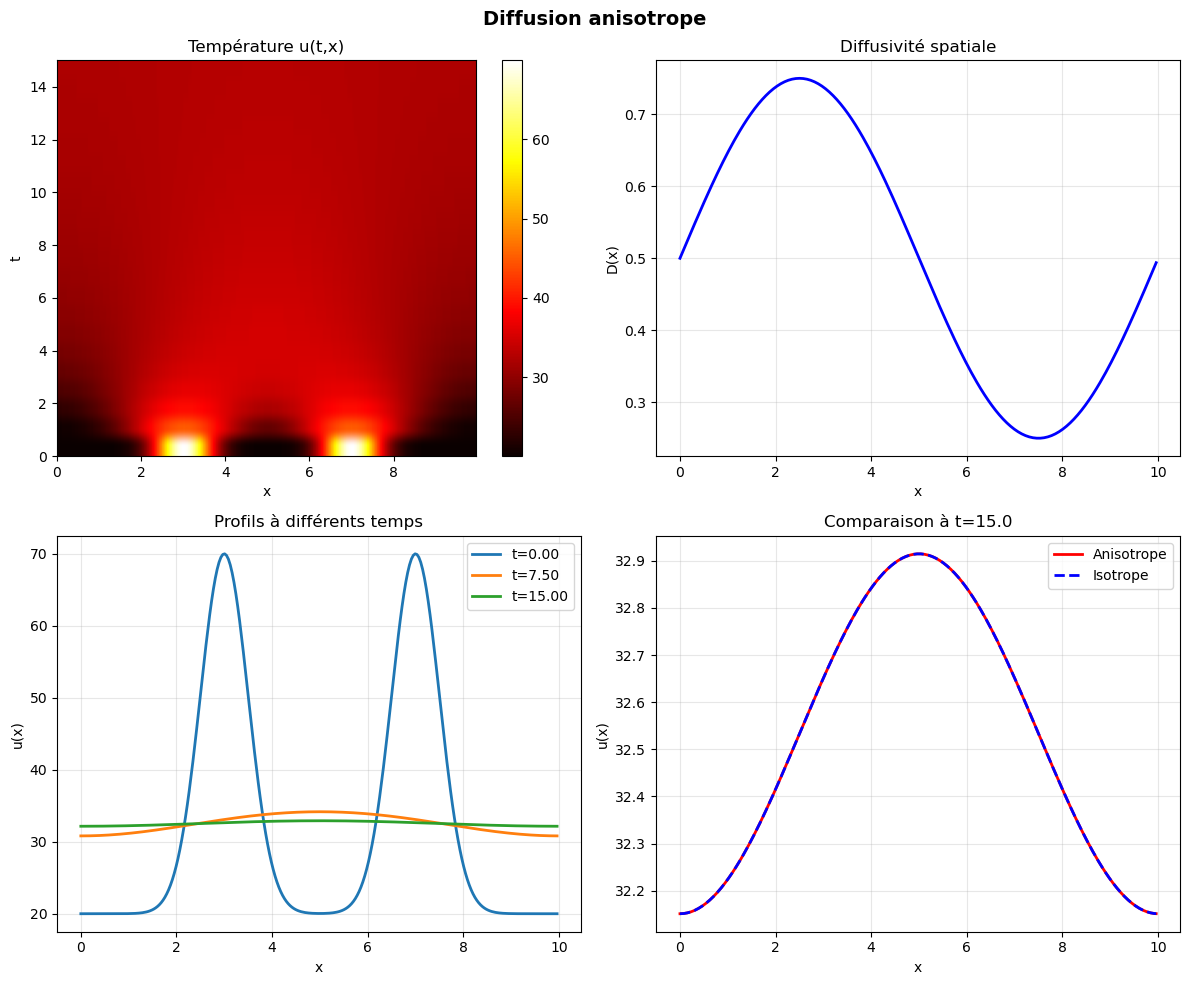

(array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 array([[20.00000076, 20.00000121, 20.00000192, ..., 20.00000302,
         20.00000192, 20.00000121],
        [20.55544977, 20.55884158, 20.56903641, ..., 20.58609229,
         20.56903641, 20.55884158],
        [22.88867352, 22.89389106, 22.90954213, ..., 22.93562206,
         22.90954213, 22.89389106],
        ...,
        [32.0194924 , 32.01964746, 32.02011253, ..., 32.02088733,
         32.02011253, 32.01964746],
        [32.09029494, 32.09042851, 32.09082915, ..., 32.09149661,
         32.09082915, 32.09042851],
        [32.15130053, 32.15141565, 32.15176091, ..., 32.15233612,
         32.15176091, 32.15141565]], shape=(21, 256)),
 Grid(x=array([0.       , 0.0390625, 0.078125 , 0.1171875, 0.15625  , 0.1953125,
        0.234375 , 0.2734375, 0.3125   , 0.3515625, 0.390625 , 0.4296875,
        0.46875  , 0.5078125

In [13]:
example_heat_anisotropic()

In [14]:
def example_heat_2d():
    """
    Équation de la chaleur en 2D
    """
    print("="*60)
    print("DIFFUSION DE CHALEUR 2D")
    print("="*60 + "\n")
    
    N = 128
    L = 10.0
    D = 0.3
    
    grid = Grid.create_2d(Nx=N, Ny=N, Lx=L, Ly=L, periodic=True)
    solver = HeatEquationSolver(grid, 'periodic', D)
    h_func = solver.create_diffusion_symbol()
    
    # Condition initiale : plusieurs sources de chaleur
    X, Y = grid.x
    
    u0 = np.zeros_like(X)
    
    # Sources ponctuelles
    sources = [(3, 3, 100), (7, 3, 80), (5, 7, 90)]
    for x0, y0, T0 in sources:
        u0 += T0 * np.exp(-((X-x0)**2 + (Y-y0)**2) / 0.5)
    
    u0 += 20.0  # Température ambiante
    
    print(f"Grille {N}×{N}, D={D}")
    print(f"Évolution...")
    
    times, u_history = solver.evolve_heat(
        u0, h_func, t_span=(0, 10), Nt=200, save_every=40
    )
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, len(u_history), figsize=(5*len(u_history), 5))
    
    for i, (ax, u) in enumerate(zip(axes, u_history)):
        im = ax.imshow(u, extent=[0, L, 0, L], origin='lower', cmap='hot',
                      vmin=20, vmax=np.max(u0))
        ax.set_title(f't={times[i]:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle('Diffusion 2D : Évolution temporelle', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig('heat_2d.png', dpi=150, bbox_inches='tight')
    print("✓ Sauvegardé : heat_2d.png")
    plt.show()
    
    return times, u_history, grid

DIFFUSION DE CHALEUR 2D

Grille 128×128, D=0.3
Évolution...
Résolution équation de la chaleur : t=0 → 10
  t=1.0000 (20/200), T_min=20.0000, T_max=49.3798, T_mean=24.2412
  t=2.0000 (40/200), T_min=20.0039, T_max=37.3009, T_mean=24.2412
  t=3.0000 (60/200), T_min=20.0465, T_max=32.4972, T_mean=24.2412
  t=4.0000 (80/200), T_min=20.1741, T_max=30.1152, T_mean=24.2412
  t=5.0000 (100/200), T_min=20.3904, T_max=28.8460, T_mean=24.2412
  t=6.0000 (120/200), T_min=20.6675, T_max=28.1605, T_mean=24.2412
  t=7.0000 (140/200), T_min=20.9729, T_max=27.7272, T_mean=24.2412
  t=8.0000 (160/200), T_min=21.2820, T_max=27.3633, T_mean=24.2412
  t=9.0000 (180/200), T_min=21.5800, T_max=27.0310, T_mean=24.2412
  t=10.0000 (200/200), T_min=21.8587, T_max=26.7265, T_mean=24.2412
✓ Résolution terminée
✓ Sauvegardé : heat_2d.png


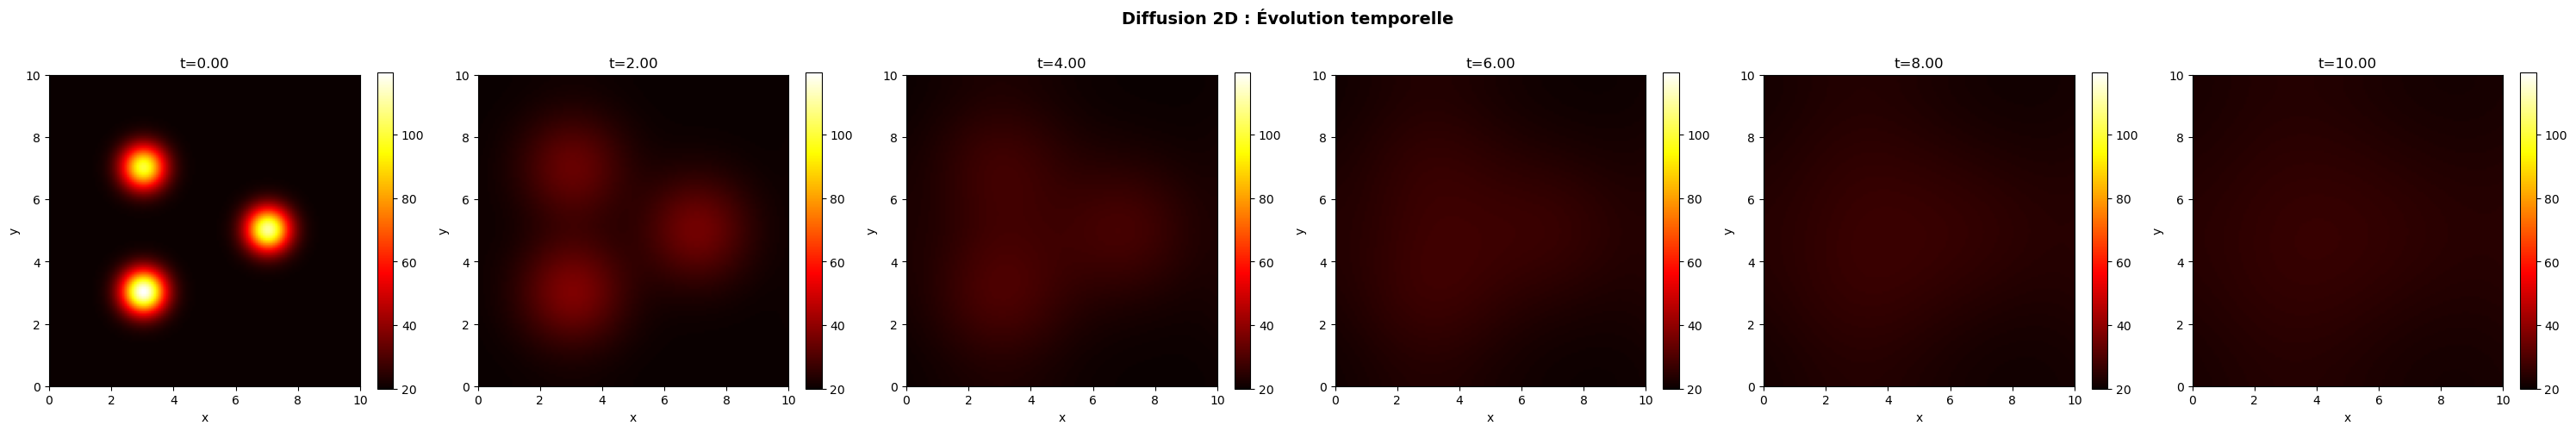

(array([ 0.,  2.,  4.,  6.,  8., 10.]),
 array([[[20.        , 20.        , 20.        , ..., 20.        ,
          20.        , 20.        ],
         [20.        , 20.        , 20.        , ..., 20.        ,
          20.        , 20.        ],
         [20.        , 20.        , 20.        , ..., 20.        ,
          20.        , 20.        ],
         ...,
         [20.        , 20.        , 20.        , ..., 20.        ,
          20.        , 20.        ],
         [20.        , 20.        , 20.        , ..., 20.        ,
          20.        , 20.        ],
         [20.        , 20.        , 20.        , ..., 20.        ,
          20.        , 20.        ]],
 
        [[20.06280085, 20.07358165, 20.08587719, ..., 20.03819279,
          20.04523657, 20.05339688],
         [20.06462104, 20.07571387, 20.08836534, ..., 20.03930108,
          20.04654857, 20.05494495],
         [20.06784772, 20.07949012, 20.09276893, ..., 20.04127668,
          20.04888155, 20.0576928 ],
       

In [15]:
example_heat_2d()

In [16]:
def example_heat_with_source():
    """
    Équation de la chaleur avec source : ∂_t u = D ∇²u + f(t,x)
    
    Modélise par exemple :
    - Chauffage localisé
    - Réaction chimique exothermique
    - Absorption/émission de rayonnement
    """
    print("="*60)
    print("DIFFUSION AVEC TERME SOURCE")
    print("="*60 + "\n")
    
    N = 256
    L = 10.0
    D = 0.5
    
    grid = Grid.create_1d(N=N, L=L, periodic=False)  # Dirichlet aux bords
    solver = HeatEquationSolver(grid, bc_type='dirichlet', diffusivity=D)
    h_func = solver.create_diffusion_symbol()
    
    # Terme source : chauffage localisé au centre
    def heat_source(t, x):
        """
        Source gaussienne qui s'allume puis s'éteint
        
        f(t,x) = A(t) exp(-(x-x₀)²/σ²)
        A(t) = A₀ sin²(πt/T) pour 0 < t < T, puis 0
        """
        x0 = L / 2
        sigma = 0.8
        A0 = 50.0
        T_on = 5.0
        
        if t < T_on:
            amplitude = A0 * np.sin(np.pi * t / T_on)**2
        else:
            amplitude = 0.0
        
        return amplitude * np.exp(-(x - x0)**2 / (2*sigma**2))
    
    # Condition initiale : température ambiante uniforme
    x = grid.x
    T_ambient = 20.0
    u0 = T_ambient * np.ones_like(x)
    
    # Conditions aux limites Dirichlet : bords maintenus à T_ambient
    # (géré automatiquement par bc_type='dirichlet')
    
    print(f"Configuration :")
    print(f"  Domaine : [0, {L}] avec Dirichlet aux bords (T={T_ambient})")
    print(f"  Source : chauffage central qui s'allume puis s'éteint")
    print(f"  Diffusivité D = {D}")
    
    T_final = 15.0
    Nt = 500
    
    print(f"\nÉvolution de t=0 à t={T_final}...")
    
    times, u_history = solver.evolve_heat(
        u0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=10,
        source_term=heat_source
    )
    
    # Diagnostics
    print("\nDiagnostics :")
    
    Q_total = [HeatDiagnostics.total_heat(u - T_ambient, grid) for u in u_history]
    T_max = [np.max(u) for u in u_history]
    
    print(f"  Chaleur injectée (Q finale) : {Q_total[-1]:.2f}")
    print(f"  Température max atteinte : {np.max(T_max):.1f}")
    print(f"  Température finale (centre) : {u_history[-1][N//2]:.1f}")
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # (a) Évolution spatio-temporelle
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = ax1.imshow(u_history, aspect='auto', origin='lower',
                    extent=extent, cmap='hot', vmin=T_ambient)
    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Temps t', fontsize=12)
    ax1.set_title('Distribution de température avec source', fontsize=14, fontweight='bold')
    
    # Marquer la période de chauffage
    ax1.axhline(5.0, color='cyan', linestyle='--', linewidth=2, 
                label='Fin du chauffage', alpha=0.7)
    ax1.legend(loc='upper right')
    
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Température (°C)', fontsize=11)
    
    # (b) Profils à différents temps
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Pendant le chauffage, au pic, après extinction
    indices_key = [0, 12, 25, 38, -1]  # Approximatif selon save_every
    colors = ['blue', 'green', 'orange', 'red', 'purple']
    labels = ['Initial', 'Chauffage', 'Pic', 'Refroidissement', 'Final']
    
    for idx, color, label in zip(indices_key, colors, labels):
        if idx < len(u_history):
            ax2.plot(grid.x, u_history[idx], color=color, linewidth=2, 
                    label=f'{label} (t={times[idx]:.1f})')
    
    ax2.axhline(T_ambient, color='k', linestyle=':', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('Température u(x)', fontsize=11)
    ax2.set_title('Profils de température', fontsize=12)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([T_ambient - 5, None])
    
    # (c) Terme source au cours du temps (au centre)
    ax3 = fig.add_subplot(gs[1, 1])
    
    source_at_center = [heat_source(t, L/2) for t in times]
    ax3.plot(times, source_at_center, 'r-', linewidth=2)
    ax3.fill_between(times, 0, source_at_center, alpha=0.3, color='red')
    ax3.set_xlabel('Temps t', fontsize=11)
    ax3.set_ylabel('Source f(t, x₀)', fontsize=11)
    ax3.set_title('Puissance du terme source (centre)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, None])
    
    # (d) Chaleur totale vs temps
    ax4 = fig.add_subplot(gs[2, 0])
    
    ax4.plot(times, Q_total, 'b-', linewidth=2)
    ax4.set_xlabel('Temps t', fontsize=11)
    ax4.set_ylabel('Chaleur totale Q (au-dessus de T_amb)', fontsize=11)
    ax4.set_title('Accumulation puis dissipation de chaleur', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.axvline(5.0, color='r', linestyle='--', linewidth=1, alpha=0.5,
                label='Fin chauffage')
    ax4.legend()
    
    # (e) Température max vs temps
    ax5 = fig.add_subplot(gs[2, 1])
    
    ax5.plot(times, T_max, 'r-', linewidth=2)
    ax5.axhline(T_ambient, color='k', linestyle=':', linewidth=1)
    ax5.set_xlabel('Temps t', fontsize=11)
    ax5.set_ylabel('Température maximale', fontsize=11)
    ax5.set_title('Évolution de T_max', fontsize=12)
    ax5.grid(True, alpha=0.3)
    ax5.axvline(5.0, color='r', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.suptitle('DIFFUSION AVEC SOURCE : Chauffage puis refroidissement', 
                 fontsize=16, fontweight='bold')
    
    filename = 'heat_with_source.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Simulation terminée !")
    print("="*60)
    
    return times, u_history, grid

DIFFUSION AVEC TERME SOURCE

Configuration :
  Domaine : [0, 10.0] avec Dirichlet aux bords (T=20.0)
  Source : chauffage central qui s'allume puis s'éteint
  Diffusivité D = 0.5

Évolution de t=0 à t=15.0...
Résolution équation de la chaleur : t=0.0 → 15.0
  t=1.5000 (50/500), T_min=0.0000, T_max=34.7219, T_mean=19.7496
  t=3.0000 (100/500), T_min=0.0000, T_max=77.7326, T_mean=31.6769
  t=4.5000 (150/500), T_min=0.0000, T_max=83.5208, T_mean=37.8694
  t=6.0000 (200/500), T_min=0.0000, T_max=68.3230, T_mean=36.4148
  t=7.5000 (250/500), T_min=0.0000, T_max=59.6137, T_mean=34.4754
  t=9.0000 (300/500), T_min=0.0000, T_max=53.5547, T_mean=32.3712
  t=10.5000 (350/500), T_min=0.0000, T_max=48.8295, T_mean=30.2455
  t=12.0000 (400/500), T_min=0.0000, T_max=44.8832, T_mean=28.1810
  t=13.5000 (450/500), T_min=0.0000, T_max=41.4420, T_mean=26.2171
  t=15.0000 (500/500), T_min=0.0000, T_max=38.3608, T_mean=24.3692
✓ Résolution terminée

Diagnostics :
  Chaleur injectée (Q finale) : 44.65
  Te

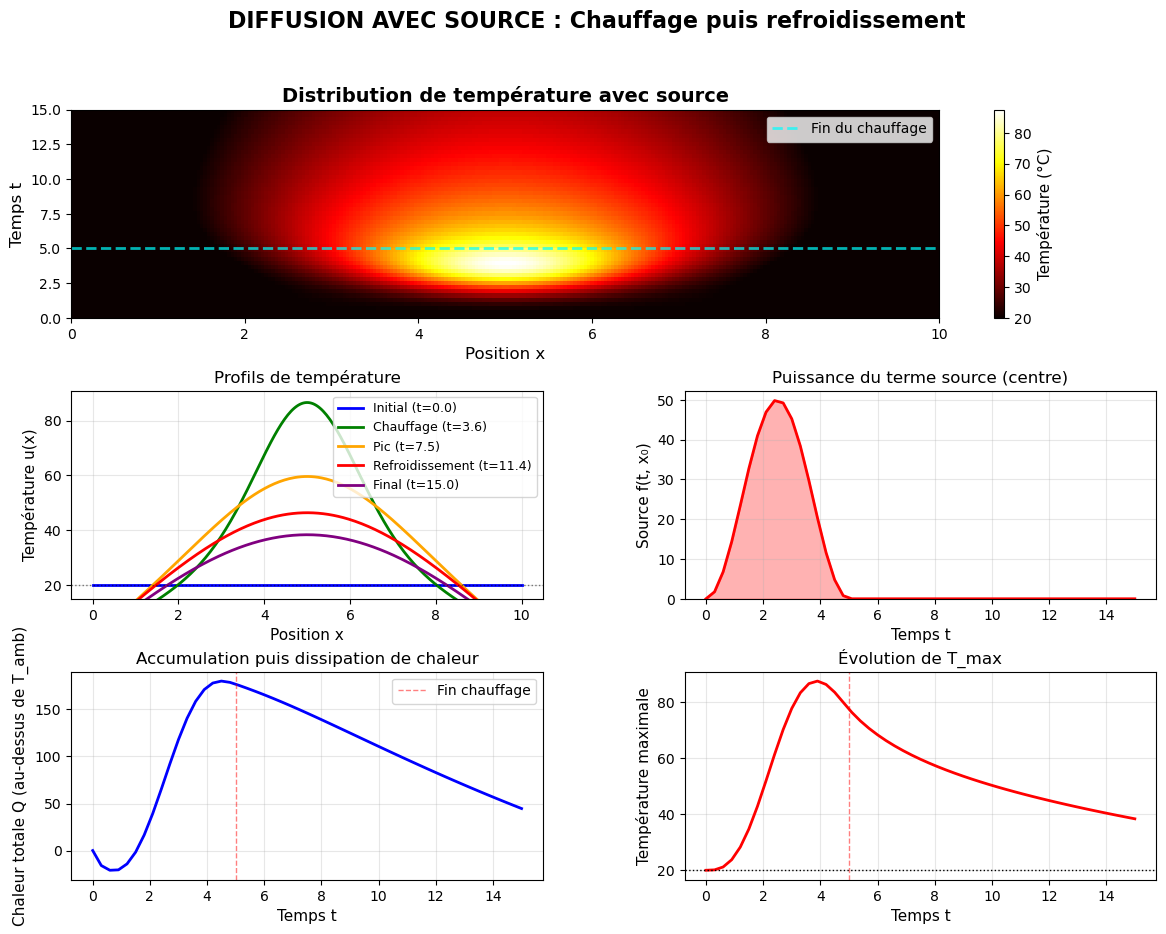


Simulation terminée !


(array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ,
         3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ,  6.3,
         6.6,  6.9,  7.2,  7.5,  7.8,  8.1,  8.4,  8.7,  9. ,  9.3,  9.6,
         9.9, 10.2, 10.5, 10.8, 11.1, 11.4, 11.7, 12. , 12.3, 12.6, 12.9,
        13.2, 13.5, 13.8, 14.1, 14.4, 14.7, 15. ]),
 array([[20.        , 20.        , 20.        , ..., 20.        ,
         20.        , 20.        ],
        [ 0.        ,  2.21420787,  3.31183444, ...,  3.31183444,
          2.21420787,  0.        ],
        [ 0.        ,  1.5670466 ,  2.34872598, ...,  2.34872598,
          1.5670466 ,  0.        ],
        ...,
        [ 0.        ,  0.92825521,  1.39403072, ...,  1.39403072,
          0.92825521,  0.        ],
        [ 0.        ,  0.91612303,  1.37580862, ...,  1.37580862,
          0.91612303,  0.        ],
        [ 0.        ,  0.90397843,  1.35756818, ...,  1.35756818,
          0.90397843,  0.        ]], shape=(51, 256)),
 Grid(x=

In [17]:
example_heat_with_source()

In [18]:
def example_fisher_kpp():
    """
    Équation de Fisher-KPP : ∂_t u = D ∇²u + r u(1 - u/K)
    
    Modèle de propagation d'une population ou d'un gène
    
    Front d'onde se propageant à vitesse c = 2√(Dr)
    """
    print("="*60)
    print("ÉQUATION DE FISHER-KPP")
    print("="*60 + "\n")
    
    N = 512
    L = 50.0
    D = 0.1
    
    grid = Grid.create_1d(N=N, L=L, periodic=False)
    
    # Paramètres de réaction
    r = 1.0  # Taux de croissance
    K = 1.0  # Capacité limite
    
    def fisher_reaction(u, params):
        """R(u) = r u(1 - u/K)"""
        r = params['r']
        K = params['K']
        return r * u * (1.0 - u / K)
    
    solver = ReactionDiffusionSolver(
        grid, bc_type='dirichlet',
        diffusivity=D,
        reaction_func=fisher_reaction
    )
    
    h_func = solver.create_diffusion_symbol()
    
    # Condition initiale : front initial raide
    x = grid.x
    x0 = 10.0
    width = 2.0
    
    u0 = K / (1.0 + np.exp((x - x0) / width))
    
    # Vitesse théorique du front
    c_theory = 2 * np.sqrt(D * r)
    
    print(f"Paramètres :")
    print(f"  D = {D}, r = {r}, K = {K}")
    print(f"  Vitesse théorique du front : c = 2√(Dr) = {c_theory:.4f}")
    
    T_final = 30.0
    Nt = 1000
    
    print(f"\nÉvolution de t=0 à t={T_final}...")
    
    times, u_history = solver.evolve_reaction_diffusion(
        u0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        reaction_params={'r': r, 'K': K},
        save_every=20
    )
    
    # Mesurer la vitesse effective du front
    # Position du front définie comme u(x_f, t) = K/2
    front_positions = []
    for u in u_history:
        # Trouver où u ≈ K/2
        idx = np.argmin(np.abs(u - K/2))
        front_positions.append(grid.x[idx])
    
    # Régression linéaire pour vitesse
    if len(times) > 2:
        from scipy.stats import linregress
        slope, intercept, r_value, _, _ = linregress(times, front_positions)
        c_measured = slope
    else:
        c_measured = 0.0
    
    print(f"\nRésultats :")
    print(f"  Vitesse mesurée du front : c = {c_measured:.4f}")
    print(f"  Erreur relative : {abs(c_measured - c_theory)/c_theory * 100:.2f}%")
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # (a) Évolution spatio-temporelle
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = ax1.imshow(u_history, aspect='auto', origin='lower',
                    extent=extent, cmap='viridis', vmin=0, vmax=K)
    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Temps t', fontsize=12)
    ax1.set_title('Propagation du front de Fisher-KPP', fontsize=14, fontweight='bold')
    
    # Trajectoire du front
    ax1.plot(front_positions, times, 'r-', linewidth=2, label=f'Front (c={c_measured:.3f})')
    ax1.plot(front_positions, times, 'r--', linewidth=2, alpha=0.5,
            label=f'Théorie (c={c_theory:.3f})')
    ax1.legend(loc='upper left')
    
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Population u', fontsize=11)
    
    # (b) Profils à différents temps
    ax2 = fig.add_subplot(gs[1, 0])
    
    indices = np.linspace(0, len(times)-1, 6, dtype=int)
    colors = plt.cm.plasma(np.linspace(0, 1, len(indices)))
    
    for idx, color in zip(indices, colors):
        ax2.plot(grid.x, u_history[idx], color=color, linewidth=2,
                label=f't={times[idx]:.1f}')
    
    ax2.axhline(K/2, color='r', linestyle=':', linewidth=1, label='u = K/2 (front)')
    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('Population u(x)', fontsize=11)
    ax2.set_title('Profils de population', fontsize=12)
    ax2.legend(fontsize=8, loc='right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([-0.05, K*1.1])
    
    # (c) Position du front vs temps
    ax3 = fig.add_subplot(gs[1, 1])
    
    ax3.plot(times, front_positions, 'b-', linewidth=2, label='Mesuré')
    ax3.plot(times, front_positions[0] + c_theory * times, 'r--', linewidth=2,
            label='Théorique')
    ax3.set_xlabel('Temps t', fontsize=11)
    ax3.set_ylabel('Position du front x_f', fontsize=11)
    ax3.set_title('Trajectoire du front', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # (d) Terme de réaction R(u)
    ax4 = fig.add_subplot(gs[2, 0])
    
    u_range = np.linspace(0, K*1.5, 200)
    R_range = fisher_reaction(u_range, {'r': r, 'K': K})
    
    ax4.plot(u_range, R_range, 'g-', linewidth=2)
    ax4.axhline(0, color='k', linestyle='-', linewidth=0.5)
    ax4.axvline(K, color='r', linestyle='--', linewidth=1, label=f'u = K')
    ax4.fill_between(u_range, 0, R_range, where=(R_range > 0), 
                     alpha=0.3, color='green', label='Croissance')
    ax4.fill_between(u_range, 0, R_range, where=(R_range < 0), 
                     alpha=0.3, color='red', label='Décroissance')
    ax4.set_xlabel('Population u', fontsize=11)
    ax4.set_ylabel('Réaction R(u)', fontsize=11)
    ax4.set_title('Terme de réaction logistique', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim([0, K*1.5])
    
    # (e) Population totale vs temps
    ax5 = fig.add_subplot(gs[2, 1])
    
    pop_total = [np.trapz(u, grid.x) for u in u_history]
    
    ax5.plot(times, pop_total, 'b-', linewidth=2)
    ax5.set_xlabel('Temps t', fontsize=11)
    ax5.set_ylabel('Population totale ∫u dx', fontsize=11)
    ax5.set_title('Croissance de la population totale', fontsize=12)
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle('ÉQUATION DE FISHER-KPP : Propagation de population', 
                 fontsize=16, fontweight='bold')
    
    filename = 'fisher_kpp.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Simulation terminée !")
    print("="*60)
    
    return times, u_history, grid

ÉQUATION DE FISHER-KPP

Paramètres :
  D = 0.1, r = 1.0, K = 1.0
  Vitesse théorique du front : c = 2√(Dr) = 0.6325

Évolution de t=0 à t=30.0...
Résolution réaction-diffusion : t=0.0 → 30.0
  t=3.0000 (100/1000), u_min=0.0000, u_max=0.9986
  t=6.0000 (200/1000), u_min=0.0000, u_max=0.9999
  t=9.0000 (300/1000), u_min=0.0000, u_max=1.0000
  t=12.0000 (400/1000), u_min=0.0000, u_max=1.0000
  t=15.0000 (500/1000), u_min=0.0000, u_max=1.0000
  t=18.0000 (600/1000), u_min=0.0000, u_max=1.0000
  t=21.0000 (700/1000), u_min=0.0000, u_max=1.0000
  t=24.0000 (800/1000), u_min=0.0000, u_max=1.0000
  t=27.0000 (900/1000), u_min=0.0000, u_max=1.0000
  t=30.0000 (1000/1000), u_min=0.0000, u_max=1.0000
✓ Résolution terminée

Résultats :
  Vitesse mesurée du front : c = -0.5963
  Erreur relative : 194.29%


/tmp/ipykernel_8281/3247773987.py:162: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pop_total = [np.trapz(u, grid.x) for u in u_history]



✓ Graphique sauvegardé : fisher_kpp.png


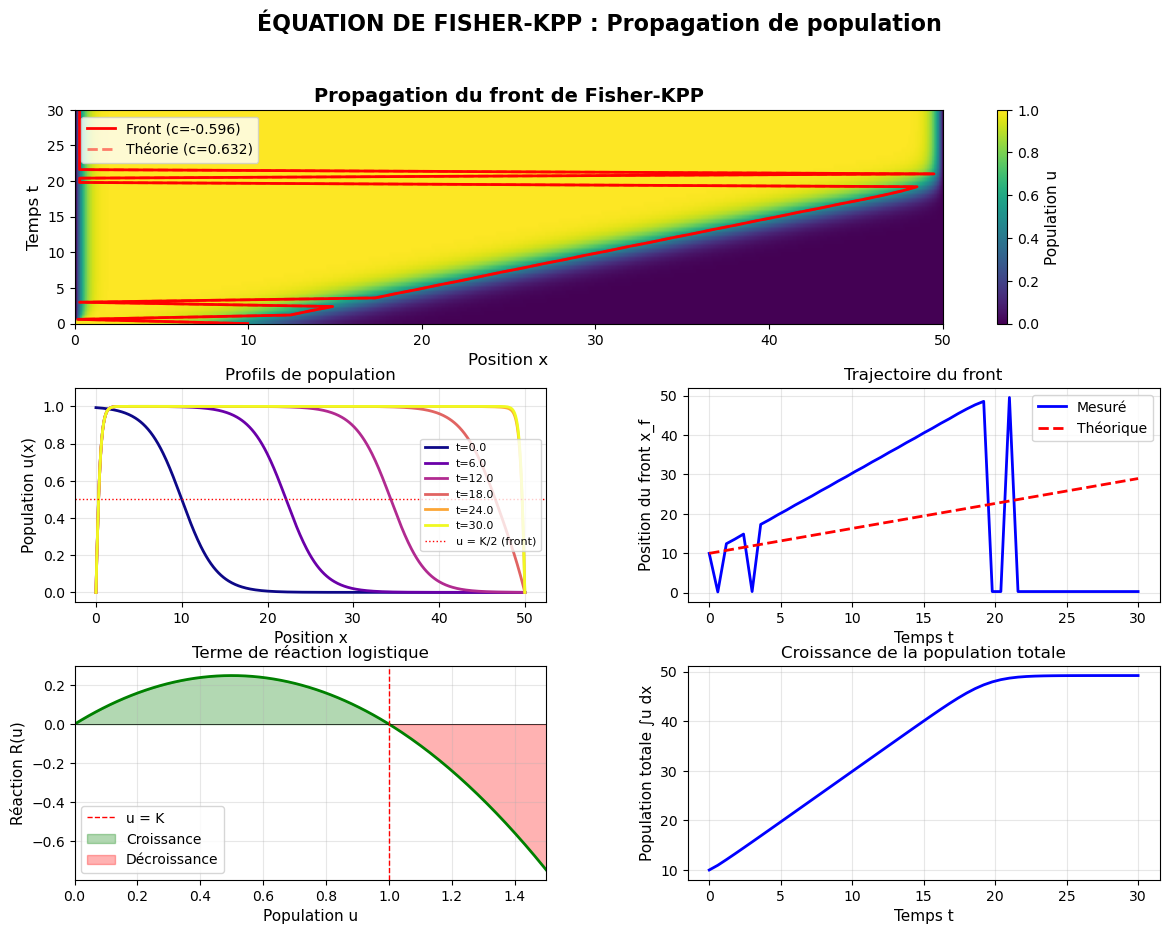


Simulation terminée !


(array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ,
         6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. , 12.6,
        13.2, 13.8, 14.4, 15. , 15.6, 16.2, 16.8, 17.4, 18. , 18.6, 19.2,
        19.8, 20.4, 21. , 21.6, 22.2, 22.8, 23.4, 24. , 24.6, 25.2, 25.8,
        26.4, 27. , 27.6, 28.2, 28.8, 29.4, 30. ]),
 array([[9.93307149e-01, 9.92973926e-01, 9.92624236e-01, ...,
         2.27302875e-09, 2.16450027e-09, 2.06115362e-09],
        [0.00000000e+00, 2.76212532e-01, 4.97878142e-01, ...,
         2.10227950e-09, 1.13220853e-09, 0.00000000e+00],
        [0.00000000e+00, 2.23956363e-01, 4.10399379e-01, ...,
         3.02940392e-09, 1.60044982e-09, 0.00000000e+00],
        ...,
        [0.00000000e+00, 1.89009914e-01, 3.49282516e-01, ...,
         3.49131892e-01, 1.88925454e-01, 0.00000000e+00],
        [0.00000000e+00, 1.89009914e-01, 3.49282516e-01, ...,
         3.49194635e-01, 1.88960635e-01, 0.00000000e+00],
        [0.00000000e+00, 1.89009914e-01

In [19]:
example_fisher_kpp()

In [ ]:
def example_gray_scott():
    """
    Motifs auto-organisés de Gray-Scott
    """
    print("="*60)
    print("SYSTÈME DE GRAY-SCOTT")
    print("="*60 + "\n")
    
    N = 64
    L = 2.5
    
    grid = Grid.create_2d(Nx=N, Ny=N, Lx=L, Ly=L, periodic=True)
    
    # Paramètres pour spots
    F = 0.026
    k = 0.055
    D_u = 2e-5
    D_v = 1e-5
    
    solver = GrayScottSolver(grid, 'periodic', D_u, D_v, F, k)
    
    # Condition initiale : u≈1, v≈0 avec perturbation locale
    X, Y = grid.x
    
    u0 = np.ones_like(X)
    v0 = np.zeros_like(X)
    
    # Ajouter quelques "graines" de v au centre
    center_x, center_y = L/2, L/2
    radius = 0.2
    
    # Graine centrale

    mask = (X - center_x)**2 + (Y - center_y)**2 < radius**2
    u0[mask] = 0.5
    v0[mask] = 0.25
    
    # Ajouter bruit pour briser la symétrie
    np.random.seed(42)
    u0 += 0.01 * np.random.randn(*u0.shape)
    v0 += 0.01 * np.random.randn(*v0.shape)
    
    u0 = np.clip(u0, 0, 1)
    v0 = np.clip(v0, 0, 1)
    
    print(f"Grille {N}×{N}, domaine {L}×{L}")
    print(f"Paramètres : F={F}, k={k} (régime: spots)")
    
    T_final = 10000.0  # Temps long pour formation des motifs
    Nt = 20000
    
    print(f"\nÉvolution (cela peut prendre quelques minutes)...")
    
    times, u_history, v_history = solver.evolve(
        u0, v0,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=Nt//20  # 20 snapshots
    )
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.25)
    
    # Montrer évolution de v (plus visuelle que u)
    n_snapshots = min(8, len(times))
    indices = np.linspace(0, len(times)-1, n_snapshots, dtype=int)
    
    for plot_idx, idx in enumerate(indices):
        row = plot_idx // 4
        col = plot_idx % 4
        ax = fig.add_subplot(gs[row, col])
        
        im = ax.imshow(v_history[idx], extent=[0, L, 0, L],
                      origin='lower', cmap='viridis', vmin=0, vmax=np.max(v_history))
        ax.set_title(f't={times[idx]:.0f}', fontsize=11)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        
        if col == 3:  # Barre de couleur à droite
            plt.colorbar(im, ax=ax, fraction=0.046)
    
    # État final en grand
    ax_final = fig.add_subplot(gs[2, :])
    im_final = ax_final.imshow(v_history[-1], extent=[0, L, 0, L],
                               origin='lower', cmap='viridis')
    ax_final.set_title(f'État final (t={times[-1]:.0f}) - Espèce v', 
                      fontsize=13, fontweight='bold')
    ax_final.set_xlabel('x', fontsize=12)
    ax_final.set_ylabel('y', fontsize=12)
    ax_final.set_aspect('equal')
    cbar_final = plt.colorbar(im_final, ax=ax_final, fraction=0.03)
    cbar_final.set_label('Concentration v', fontsize=11)
    
    plt.suptitle(f'GRAY-SCOTT : Auto-organisation (F={F}, k={k})', 
                 fontsize=16, fontweight='bold')
    
    filename = 'gray_scott.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Motifs de Gray-Scott générés !")
    print("="*60)
    print("\nPour explorer d'autres motifs, essayez :")
    print("  • F=0.014, k=0.054  → stripes")
    print("  • F=0.022, k=0.059  → spots mobiles")
    print("  • F=0.030, k=0.062  → ondes")
    print("  • F=0.026, k=0.055  → spirales")
    
    return times, u_history, v_history, grid

In [ ]:
example_gray_scott()

In [20]:

def example_advection_diffusion_2d_vortex():
    """
    Transport dans un champ de vélocité tourbillonnaire
    """
    print("="*60)
    print("ADVECTION-DIFFUSION 2D : VORTEX")
    print("="*60 + "\n")
    
    N = 64
    L = 2.0
    D = 0.001
    
    grid = Grid.create_2d(Nx=N, Ny=N, Lx=L, Ly=L, periodic=True)
    
    # Champ de vélocité : vortex au centre
    def vortex_velocity(t, X, Y):
        """
        Vélocité tangentielle autour du centre
        v_r = 0, v_θ = ω r
        
        En cartésien :
        v_x = -ω (y - y_c)
        v_y = +ω (x - x_c)
        """
        omega = 2.0  # Vitesse angulaire
        x_c, y_c = L/2, L/2
        
        v_x = -omega * (Y - y_c)
        v_y = +omega * (X - x_c)
        
        return v_x, v_y
    
    solver = AdvectionDiffusionSolver(
        grid, bc_type='periodic',
        diffusivity=D,
        velocity_field=vortex_velocity
    )
    
    # Condition initiale : tache décentrée
    X, Y = grid.x
    x0, y0 = L/2 + 0.4, L/2
    sigma = 0.1
    
    u0 = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2*sigma**2))
    
    print(f"Grille {N}×{N}, domaine {L}×{L}")
    print(f"Diffusivité D = {D}")
    print(f"Vortex ω = 2.0")
    
    T_final = 3.14  # Une demi-rotation
    Nt = 200
    
    print(f"\nÉvolution (transport par vortex)...")
    
    times, u_history = solver.evolve_advection_diffusion(
        u0, t_span=(0.0, T_final), Nt=Nt, save_every=Nt//8
    )
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(16, 10))
    
    n_snapshots = len(u_history)
    ncols = 3
    nrows = (n_snapshots + ncols - 1) // ncols
    
    for i, u in enumerate(u_history):
        ax = fig.add_subplot(nrows, ncols, i+1)
        
        im = ax.imshow(u, extent=[0, L, 0, L], origin='lower',
                      cmap='hot', vmin=0, vmax=np.max(u0))
        
        # Superposer champ de vélocité
        x_arrow = np.linspace(0, L, 10)
        y_arrow = np.linspace(0, L, 10)
        X_arrow, Y_arrow = np.meshgrid(x_arrow, y_arrow)
        
        v_x, v_y = vortex_velocity(times[i], X_arrow, Y_arrow)
        
        # Normaliser pour la visualisation
        v_norm = np.sqrt(v_x**2 + v_y**2)
        v_x_norm = v_x / (v_norm + 1e-10)
        v_y_norm = v_y / (v_norm + 1e-10)
        
        ax.quiver(X_arrow, Y_arrow, v_x_norm, v_y_norm,
                 color='cyan', alpha=0.5, scale=20)
        
        ax.set_title(f't={times[i]:.2f}', fontsize=11)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        
        if (i % ncols) == (ncols - 1):
            plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle('TRANSPORT PAR VORTEX : Advection-diffusion 2D', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = 'advection_diffusion_2d_vortex.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("La tache est transportée par le vortex tout en diffusant !")
    print("="*60)
    
    return times, u_history, grid

ADVECTION-DIFFUSION 2D : VORTEX

Grille 64×64, domaine 2.0×2.0
Diffusivité D = 0.001
Vortex ω = 2.0

Évolution (transport par vortex)...
Résolution advection-diffusion : t=0.0 → 3.14
  t=0.3140 (20/200)
  t=0.6280 (40/200)
  t=0.9420 (60/200)
  t=1.2560 (80/200)
  t=1.5700 (100/200)
  t=1.8840 (120/200)
  t=2.1980 (140/200)
  t=2.5120 (160/200)
  t=2.8260 (180/200)
  t=3.1400 (200/200)
✓ Résolution terminée
✓ Graphique sauvegardé : advection_diffusion_2d_vortex.png


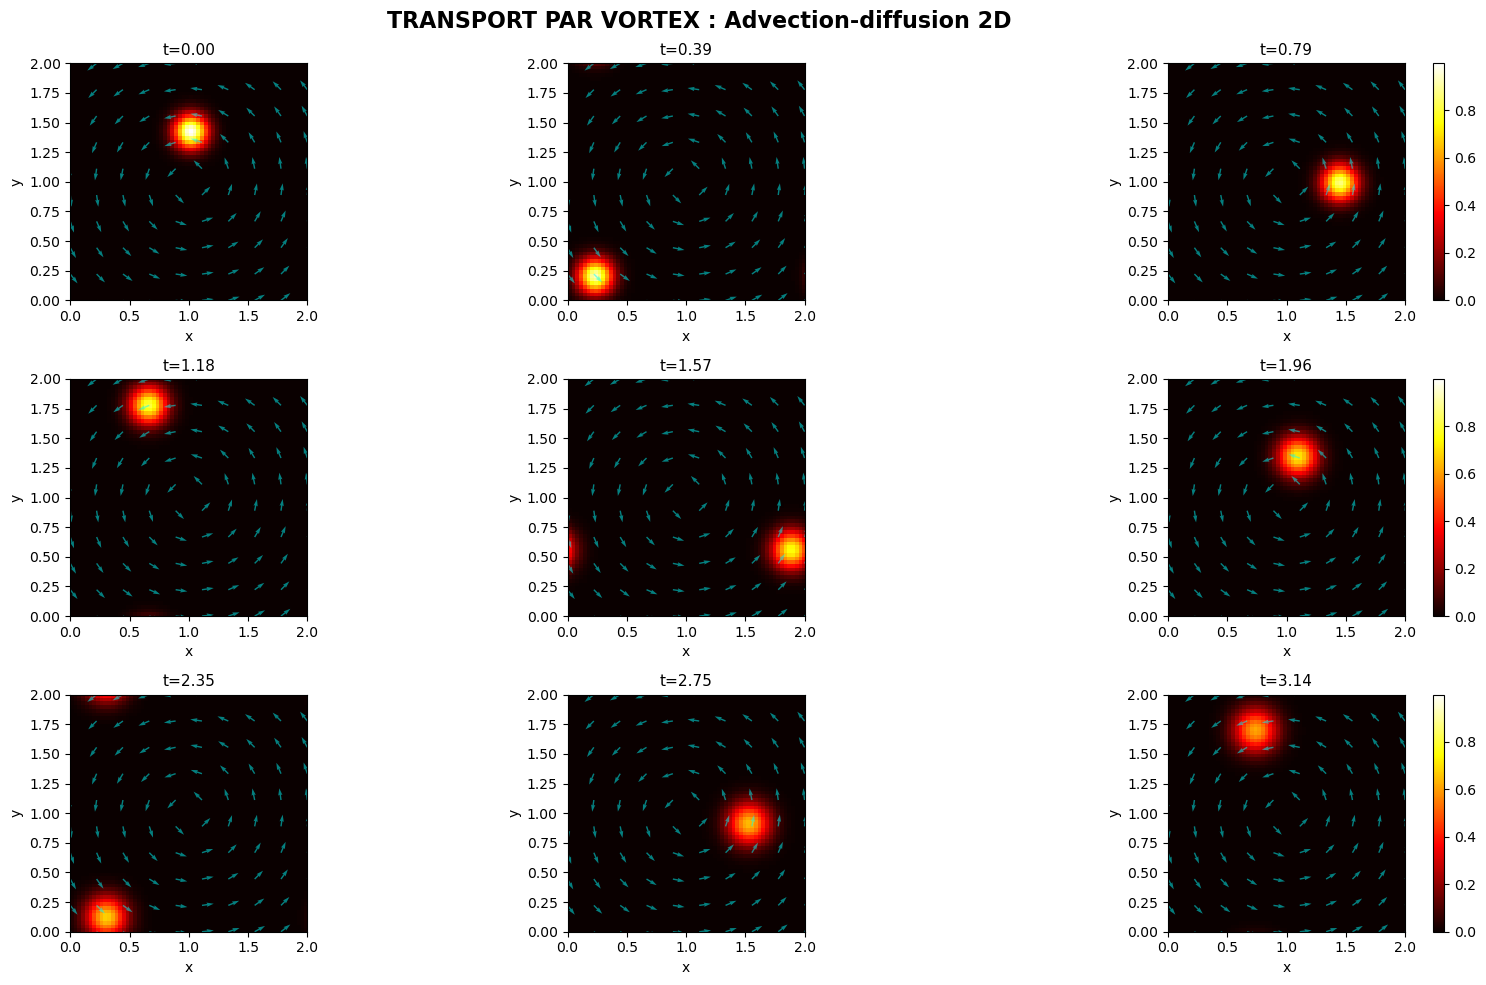


La tache est transportée par le vortex tout en diffusant !


(array([0.    , 0.3925, 0.785 , 1.1775, 1.57  , 1.9625, 2.355 , 2.7475,
        3.14  ]),
 array([[[ 5.30171867e-65,  1.14916172e-63,  2.25909268e-62, ...,
           4.02786939e-61,  2.25909268e-62,  1.14916172e-63],
         [ 4.01096850e-63,  8.69388162e-62,  1.70909665e-60, ...,
           3.04724906e-59,  1.70909665e-60,  8.69388162e-62],
         [ 2.75213830e-61,  5.96533345e-60,  1.17270189e-58, ...,
           2.09087926e-57,  1.17270189e-58,  5.96533345e-60],
         ...,
         [ 5.24843260e-28,  1.13761182e-26,  2.23638718e-25, ...,
           3.98738641e-24,  2.23638718e-25,  1.13761182e-26],
         [ 1.02743983e-28,  2.22700334e-27,  4.37797994e-26, ...,
           7.80575826e-25,  4.37797994e-26,  2.22700334e-27],
         [ 1.82419642e-29,  3.95399458e-28,  7.77300541e-27, ...,
           1.38589491e-25,  7.77300541e-27,  3.95399458e-28]],
 
        [[ 2.22527788e-02,  3.96529166e-02,  6.45418533e-02, ...,
           2.28435741e-03,  5.34107542e-03,  1.14069300e-02

In [21]:
example_advection_diffusion_2d_vortex()

In [22]:
def example_advection_diffusion_1d():
    """
    Transport et diffusion d'un polluant dans un fluide en mouvement
    """
    print("="*60)
    print("ADVECTION-DIFFUSION 1D")
    print("="*60 + "\n")
    
    N = 512
    L = 20.0
    D = 0.1
    
    grid = Grid.create_1d(N=N, L=L, periodic=True)
    
    # Champ de vélocité : écoulement vers la droite
    v0 = 2.0  # Vitesse constante
    
    def velocity_field(t, x):
        """Écoulement uniforme vers la droite"""
        return v0 * np.ones_like(x)
    
    solver = AdvectionDiffusionSolver(
        grid, bc_type='periodic',
        diffusivity=D,
        velocity_field=velocity_field
    )
    
    # Condition initiale : pic gaussien
    x = grid.x
    x0 = 5.0
    sigma = 0.5
    u0 = np.exp(-(x - x0)**2 / (2*sigma**2))
    
    # Nombre de Péclet : Pe = vL/D (importance relative advection/diffusion)
    Pe = v0 * L / D
    
    print(f"Paramètres :")
    print(f"  Vitesse v = {v0}")
    print(f"  Diffusivité D = {D}")
    print(f"  Nombre de Péclet Pe = vL/D = {Pe:.1f}")
    if Pe > 1:
        print(f"  → Advection dominante")
    else:
        print(f"  → Diffusion dominante")
    
    T_final = 5.0
    Nt = 500
    
    print(f"\nÉvolution de t=0 à t={T_final}...")
    
    times, u_history = solver.evolve_advection_diffusion(
        u0, t_span=(0.0, T_final), Nt=Nt, save_every=10
    )
    
    # Position théorique du pic : x_pic(t) = x0 + v0*t (en périodique : modulo L)
    x_theory = (x0 + v0 * times) % L
    
    # Mesurer position du pic
    x_measured = [grid.x[np.argmax(u)] for u in u_history]
    
    print(f"\nDéplacement du pic :")
    print(f"  Position initiale : x = {x0}")
    print(f"  Position théorique finale : x = {x_theory[-1]:.2f}")
    print(f"  Position mesurée finale : x = {x_measured[-1]:.2f}")
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # (a) Évolution spatio-temporelle
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = ax1.imshow(u_history, aspect='auto', origin='lower',
                    extent=extent, cmap='hot')
    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Temps t', fontsize=12)
    ax1.set_title('Transport et diffusion', fontsize=14, fontweight='bold')
    
    # Trajectoire théorique
    ax1.plot(x_theory, times, 'c--', linewidth=2, label='Théorie (advection pure)')
    ax1.plot(x_measured, times, 'b-', linewidth=2, label='Mesuré')
    ax1.legend(loc='upper left')
    
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Concentration', fontsize=11)
    
    # (b) Profils à différents temps
    ax2 = fig.add_subplot(gs[1, 0])
    
    indices = [0, len(times)//4, len(times)//2, 3*len(times)//4, -1]
    colors = plt.cm.plasma(np.linspace(0, 1, len(indices)))
    
    for idx, color in zip(indices, colors):
        ax2.plot(grid.x, u_history[idx], color=color, linewidth=2,
                label=f't={times[idx]:.2f}')
    
    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('Concentration u(x)', fontsize=11)
    ax2.set_title('Profils de concentration', fontsize=12)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # (c) Champ de vélocité
    ax3 = fig.add_subplot(gs[1, 1])
    
    v_profile = velocity_field(0, grid.x)
    ax3.plot(grid.x, v_profile, 'b-', linewidth=2)
    ax3.fill_between(grid.x, 0, v_profile, alpha=0.3)
    ax3.set_xlabel('Position x', fontsize=11)
    ax3.set_ylabel('Vélocité v(x)', fontsize=11)
    ax3.set_title('Champ de vélocité', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    # (d) Comparaison : advection seule vs advection-diffusion
    ax4 = fig.add_subplot(gs[2, 0])
    
    # État final avec advection-diffusion
    ax4.plot(grid.x, u_history[-1], 'b-', linewidth=2, 
            label=f'Advection-Diffusion (Pe={Pe:.1f})')
    
    # État final théorique (advection pure, pas de diffusion)
    u_advection_only = np.exp(-((grid.x - x_theory[-1])**2) / (2*sigma**2))
    ax4.plot(grid.x, u_advection_only, 'r--', linewidth=2,
            label='Advection seule')
    
    ax4.set_xlabel('Position x', fontsize=11)
    ax4.set_ylabel('u(x)', fontsize=11)
    ax4.set_title(f'État final (t={times[-1]:.2f})', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # (e) Étalement du pic (écart-type)
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Calculer écart-type σ(t)
    sigmas = []
    for u in u_history:
        # Centrer autour du pic
        x_peak = grid.x[np.argmax(u)]
        x_centered = (grid.x - x_peak + L/2) % L - L/2
        
        mean_x = np.trapz(x_centered * u, x_centered) / np.trapz(u, x_centered)
        var_x = np.trapz((x_centered - mean_x)**2 * u, x_centered) / np.trapz(u, x_centered)
        sigma_t = np.sqrt(var_x)
        sigmas.append(sigma_t)
    
    # Théorie : σ²(t) = σ²(0) + 2Dt
    sigma_theory = np.sqrt(sigma**2 + 2*D*times)
    
    ax5.plot(times, sigmas, 'b-', linewidth=2, label='Mesuré')
    ax5.plot(times, sigma_theory, 'r--', linewidth=2, label='Théorie')
    ax5.set_xlabel('Temps t', fontsize=11)
    ax5.set_ylabel('Écart-type σ(t)', fontsize=11)
    ax5.set_title('Étalement par diffusion', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle(f'ADVECTION-DIFFUSION : Transport avec diffusion (Pe={Pe:.1f})', 
                 fontsize=16, fontweight='bold')
    
    filename = 'advection_diffusion_1d.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Simulation terminée !")
    print("="*60)
    
    return times, u_history, grid

ADVECTION-DIFFUSION 1D

Paramètres :
  Vitesse v = 2.0
  Diffusivité D = 0.1
  Nombre de Péclet Pe = vL/D = 400.0
  → Advection dominante

Évolution de t=0 à t=5.0...
Résolution advection-diffusion : t=0.0 → 5.0
  t=0.5000 (50/500)
  t=1.0000 (100/500)
  t=1.5000 (150/500)
  t=2.0000 (200/500)
  t=2.5000 (250/500)
  t=3.0000 (300/500)
  t=3.5000 (350/500)
  t=4.0000 (400/500)
  t=4.5000 (450/500)
  t=5.0000 (500/500)
✓ Résolution terminée

Déplacement du pic :
  Position initiale : x = 5.0
  Position théorique finale : x = 15.00
  Position mesurée finale : x = 15.00


/tmp/ipykernel_8281/3735363664.py:146: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x_centered * u, x_centered) / np.trapz(u, x_centered)
/tmp/ipykernel_8281/3735363664.py:147: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var_x = np.trapz((x_centered - mean_x)**2 * u, x_centered) / np.trapz(u, x_centered)



✓ Graphique sauvegardé : advection_diffusion_1d.png


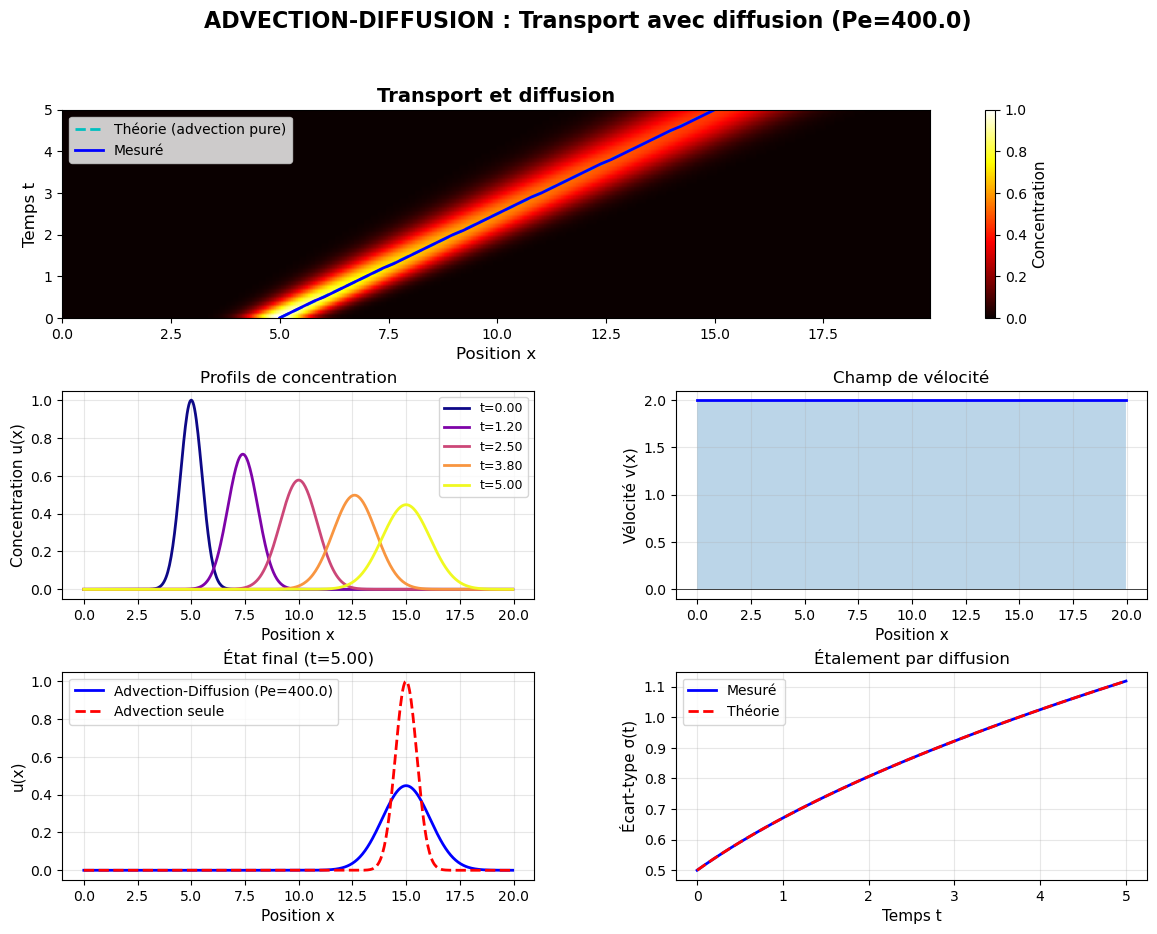


Simulation terminée !


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 array([[ 1.92874985e-022,  4.19994020e-022,  9.08991007e-022, ...,
          4.06619278e-193,  3.96220627e-194,  3.83738589e-195],
        [ 2.34187669e-017, -2.03830008e-017, -3.23092247e-017, ...,
          4.73817313e-017,  5.88784672e-017,  4.73817313e-017],
        [ 8.32667268e-017,  2.77555756e-017,  4.33680869e-017, ...,
          3.69909134e-017,  6.67190170e-017,  1.11022302e-016],
        ...,
        [ 2.65771418e-006,  2.23112821e-006,  1.87065247e-006, ...,
          4.45834313e-006,  3.75692698e-006,  3.16187247e-006],
        [ 7.59117489e-006,  6.43160309e-006,  5.44240314e-006, ...,
          1.23892693e-005,  1.05359142e-005,  8.94870093e-006],
        [ 2.03034658e-005,  1.73558782

In [23]:
example_advection_diffusion_1d()

In [24]:
def example_wave_1d_string():
    """
    Vibration d'une corde : équation d'onde 1D classique
    
    Simule une corde de guitare pincée puis relâchée
    """
    print("="*60)
    print("ÉQUATION D'ONDE 1D : Corde vibrante")
    print("="*60 + "\n")
    
    # ============================================
    # 1. PARAMÈTRES
    # ============================================
    N = 128
    L = 1.0  # Longueur de la corde (m)
    c = 100.0  # Vitesse de l'onde (m/s)
    
    # Période fondamentale
    T_period = WaveDiagnostics.wave_period(c, L, mode=1)
    
    print(f"Paramètres :")
    print(f"  Longueur corde L = {L} m")
    print(f"  Vitesse onde c = {c} m/s")
    print(f"  Période fondamentale T = {T_period:.4f} s")
    print(f"  Fréquence fondamentale f = {1/T_period:.2f} Hz")
    
    # ============================================
    # 2. GRILLE ET SOLVEUR
    # ============================================
    grid = Grid.create_1d(N=N, L=L, periodic=False)  # Bords fixes (Dirichlet)
    solver = WaveEquationSolver(grid, bc_type='dirichlet', wave_speed=c)
    h_func = solver.create_wave_symbol()
    
    # ============================================
    # 3. CONDITION INITIALE : CORDE PINCÉE
    # ============================================
    x = grid.x
    
    # Triangle : corde pincée au centre puis relâchée
    x_pinch = L / 2
    amplitude = 0.01  # 1 cm
    
    # Profil triangulaire
    u0 = np.where(x < x_pinch,
                 amplitude * x / x_pinch,
                 amplitude * (L - x) / (L - x_pinch))
    
    # Vitesse initiale nulle (relâché du repos)
    v0 = np.zeros_like(x)
    
    # Forcer Dirichlet
    u0[0] = 0.0
    u0[-1] = 0.0
    
    print(f"\nCondition initiale :")
    print(f"  Corde pincée à x = {x_pinch} m")
    print(f"  Amplitude = {amplitude*100} cm")
    print(f"  Relâchée du repos (v₀ = 0)")
    
    # ============================================
    # 4. ÉVOLUTION
    # ============================================
    T_final = 3 * T_period  # Observer 3 périodes
    Nt = 2000
    
    print(f"\nÉvolution sur {T_final/T_period:.1f} périodes...")
    
    times, u_history, v_history = solver.evolve_wave(
        u0, v0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=20,
        damping=0.0  # Pas d'amortissement
    )
    
    # ============================================
    # 5. DIAGNOSTICS
    # ============================================
    print("\nDiagnostics :")
    
    # Énergie au cours du temps
    energies = [WaveDiagnostics.total_energy(u, v, c, grid) 
               for u, v in zip(u_history, v_history)]
    
    E_initial = energies[0]
    E_final = energies[-1]
    
    print(f"  Énergie initiale : {E_initial:.6e}")
    print(f"  Énergie finale : {E_final:.6e}")
    print(f"  Conservation : {(E_final/E_initial - 1)*100:.3f}%")
    
    # ============================================
    # 6. ANALYSE DE FOURIER
    # ============================================
    # Décomposer en modes propres (pour vérification)
    # Les modes propres sont sin(nπx/L) avec fréquences f_n = nc/(2L)
    
    modes_freqs = [(n, n*c/(2*L)) for n in range(1, 6)]
    
    print(f"\nModes propres théoriques :")
    for n, f in modes_freqs:
        print(f"  Mode {n} : f = {f:.2f} Hz, T = {1/f:.4f} s")
    
    # ============================================
    # 7. VISUALISATION
    # ============================================
    print("\nGénération des graphiques...")
    
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)
    
    # (a) Évolution spatio-temporelle du déplacement
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = ax1.imshow(u_history, aspect='auto', origin='lower',
                    extent=extent, cmap='RdBu_r', 
                    vmin=-amplitude, vmax=amplitude)
    ax1.set_xlabel('Position x (m)', fontsize=12)
    ax1.set_ylabel('Temps t (s)', fontsize=12)
    ax1.set_title('Déplacement de la corde u(t,x)', fontsize=14, fontweight='bold')
    
    # Marquer les périodes
    for i in range(1, 4):
        ax1.axhline(i * T_period, color='white', linestyle='--', 
                   linewidth=1, alpha=0.5)
    
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Déplacement u (m)', fontsize=11)
    
    # (b) Snapshots à différents temps
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Montrer un cycle complet
    n_snapshots = 8
    indices = np.linspace(0, np.argmin(np.abs(times - T_period)), 
                         n_snapshots, dtype=int)
    colors = plt.cm.twilight(np.linspace(0, 1, n_snapshots))
    
    for idx, color in zip(indices, colors):
        ax2.plot(grid.x, u_history[idx], color=color, linewidth=2,
                label=f't={times[idx]/T_period:.2f}T', alpha=0.7)
    
    ax2.axhline(0, color='k', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Position x (m)', fontsize=11)
    ax2.set_ylabel('Déplacement u (m)', fontsize=11)
    ax2.set_title('Profils sur une période', fontsize=12)
    ax2.legend(fontsize=8, ncol=2)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([-amplitude*1.2, amplitude*1.2])
    
    # (c) Évolution temporelle au centre
    ax3 = fig.add_subplot(gs[1, 1])
    
    idx_center = N // 2
    u_center = [u[idx_center] for u in u_history]
    
    ax3.plot(times, u_center, 'b-', linewidth=2)
    ax3.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    # Marquer les périodes
    for i in range(1, 4):
        ax3.axvline(i * T_period, color='r', linestyle='--', 
                   linewidth=1, alpha=0.5)
    
    ax3.set_xlabel('Temps t (s)', fontsize=11)
    ax3.set_ylabel('u(x=L/2, t) (m)', fontsize=11)
    ax3.set_title('Oscillation au centre de la corde', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # (d) Énergie vs temps
    ax4 = fig.add_subplot(gs[2, 0])
    
    E_kin = [0.5 * np.trapz(v**2, grid.x) for v in v_history]
    E_pot = [energies[i] - E_kin[i] for i in range(len(energies))]
    
    ax4.plot(times, energies, 'k-', linewidth=2, label='E_totale')
    ax4.plot(times, E_kin, 'r-', linewidth=1.5, alpha=0.7, label='E_cinétique')
    ax4.plot(times, E_pot, 'b-', linewidth=1.5, alpha=0.7, label='E_potentielle')
    
    ax4.set_xlabel('Temps t (s)', fontsize=11)
    ax4.set_ylabel('Énergie (J)', fontsize=11)
    ax4.set_title('Conservation de l\'énergie', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # (e) Spectre de Fourier (FFT temporelle au centre)
    ax5 = fig.add_subplot(gs[2, 1])
    
    # FFT du signal temporel au centre
    from scipy.fft import rfft, rfftfreq
    
    u_center_array = np.array(u_center)
    dt_avg = times[1] - times[0]
    
    spectrum = np.abs(rfft(u_center_array))
    freqs = rfftfreq(len(u_center_array), dt_avg)
    
    ax5.plot(freqs, spectrum, 'b-', linewidth=1.5)
    
    # Marquer les fréquences théoriques
    for n, f in modes_freqs[:3]:
        ax5.axvline(f, color='r', linestyle='--', linewidth=1, alpha=0.5,
                   label=f'Mode {n}: {f:.1f} Hz' if n == 1 else '')
    
    ax5.set_xlabel('Fréquence (Hz)', fontsize=11)
    ax5.set_ylabel('Amplitude spectrale', fontsize=11)
    ax5.set_title('Spectre de Fourier (centre de la corde)', fontsize=12)
    ax5.set_xlim([0, 5*c/(2*L)])  # Montrer les 5 premiers modes
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # (f) Diagramme espace-temps avec caractéristiques
    ax6 = fig.add_subplot(gs[3, :])
    
    im2 = ax6.imshow(np.abs(v_history), aspect='auto', origin='lower',
                     extent=extent, cmap='hot')
    ax6.set_xlabel('Position x (m)', fontsize=12)
    ax6.set_ylabel('Temps t (s)', fontsize=12)
    ax6.set_title('Vitesse |v(t,x)| avec caractéristiques', fontsize=14, fontweight='bold')
    
    # Tracer les caractéristiques (droites x ± ct = const)
    t_char = np.linspace(0, T_final, 100)
    
    # Caractéristiques partant du centre
    x_char_right = x_pinch + c * t_char
    x_char_left = x_pinch - c * t_char
    
    # Limiter au domaine et gérer les réflexions
    for i in range(5):  # Quelques réflexions
        offset = i * 2 * L
        ax6.plot(np.clip(x_char_right - offset, 0, L), t_char, 
                'c--', linewidth=1, alpha=0.5)
        ax6.plot(np.clip(-x_char_left + offset, 0, L), t_char, 
                'c--', linewidth=1, alpha=0.5)
    
    cbar2 = plt.colorbar(im2, ax=ax6)
    cbar2.set_label('|v| (m/s)', fontsize=11)
    
    plt.suptitle(f'CORDE VIBRANTE : Équation d\'onde 1D (c={c} m/s, f₁={1/T_period:.1f} Hz)', 
                 fontsize=16, fontweight='bold')
    
    filename = 'wave_1d_string.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Simulation terminée !")
    print("="*60)
    
    return times, u_history, v_history, grid

ÉQUATION D'ONDE 1D : Corde vibrante

Paramètres :
  Longueur corde L = 1.0 m
  Vitesse onde c = 100.0 m/s
  Période fondamentale T = 0.0200 s
  Fréquence fondamentale f = 50.00 Hz

Condition initiale :
  Corde pincée à x = 0.5 m
  Amplitude = 1.0 cm
  Relâchée du repos (v₀ = 0)

Évolution sur 3.0 périodes...
Résolution équation d'onde : t=0.0 → 0.06
  Vitesse c = 100.0
  t=0.0060 (200/2000), E_cin=1.5909e+00, E_pot=2.0478e-06
  t=0.0120 (400/2000), E_cin=8.9240e-01, E_pot=9.7478e-06
  t=0.0180 (600/2000), E_cin=6.8606e-01, E_pot=1.2103e-05
  t=0.0240 (800/2000), E_cin=1.7928e+00, E_pot=6.5498e-07
  t=0.0300 (1000/2000), E_cin=1.9424e-01, E_pot=1.6069e-05
  t=0.0360 (1200/2000), E_cin=1.3828e+00, E_pot=3.9967e-06
  t=0.0420 (1400/2000), E_cin=1.0971e+00, E_pot=7.2702e-06
  t=0.0480 (1600/2000), E_cin=4.7947e-01, E_pot=1.4137e-05
  t=0.0540 (1800/2000), E_cin=2.0068e+00, E_pot=1.8431e-08
  t=0.0600 (2000/2000), E_cin=3.9589e-01, E_pot=1.4807e-05
✓ Résolution terminée

Diagnostics :
  Éne

/tmp/ipykernel_8281/237118562.py:176: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  E_kin = [0.5 * np.trapz(v**2, grid.x) for v in v_history]


✓ Graphique sauvegardé : wave_1d_string.png


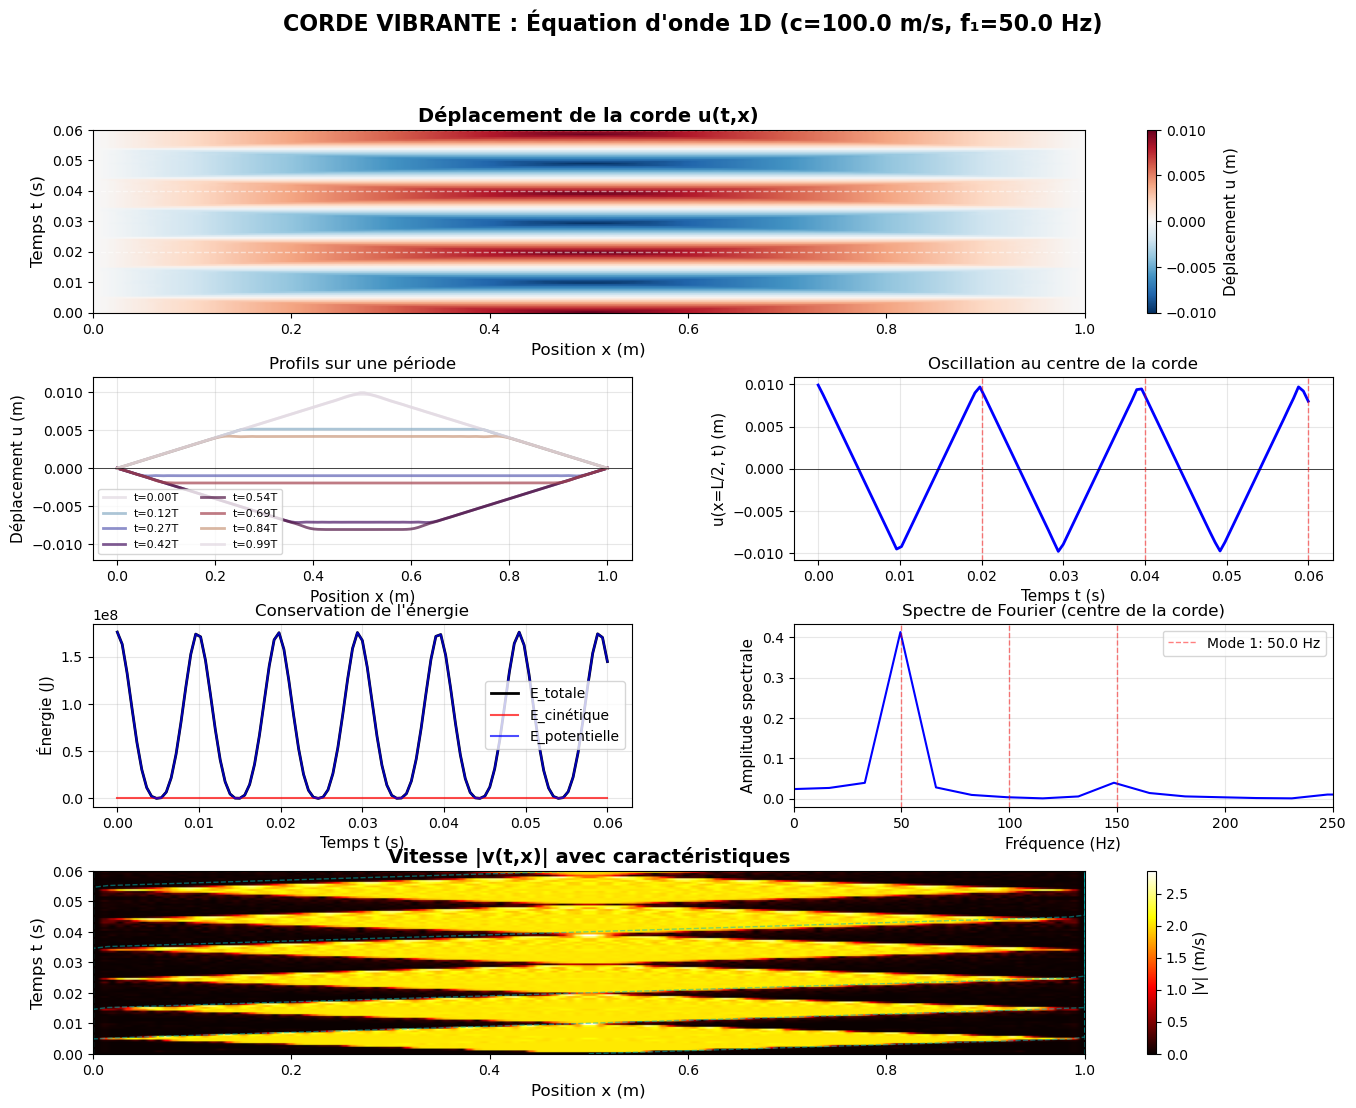


Simulation terminée !


(array([0.    , 0.0006, 0.0012, 0.0018, 0.0024, 0.003 , 0.0036, 0.0042,
        0.0048, 0.0054, 0.006 , 0.0066, 0.0072, 0.0078, 0.0084, 0.009 ,
        0.0096, 0.0102, 0.0108, 0.0114, 0.012 , 0.0126, 0.0132, 0.0138,
        0.0144, 0.015 , 0.0156, 0.0162, 0.0168, 0.0174, 0.018 , 0.0186,
        0.0192, 0.0198, 0.0204, 0.021 , 0.0216, 0.0222, 0.0228, 0.0234,
        0.024 , 0.0246, 0.0252, 0.0258, 0.0264, 0.027 , 0.0276, 0.0282,
        0.0288, 0.0294, 0.03  , 0.0306, 0.0312, 0.0318, 0.0324, 0.033 ,
        0.0336, 0.0342, 0.0348, 0.0354, 0.036 , 0.0366, 0.0372, 0.0378,
        0.0384, 0.039 , 0.0396, 0.0402, 0.0408, 0.0414, 0.042 , 0.0426,
        0.0432, 0.0438, 0.0444, 0.045 , 0.0456, 0.0462, 0.0468, 0.0474,
        0.048 , 0.0486, 0.0492, 0.0498, 0.0504, 0.051 , 0.0516, 0.0522,
        0.0528, 0.0534, 0.054 , 0.0546, 0.0552, 0.0558, 0.0564, 0.057 ,
        0.0576, 0.0582, 0.0588, 0.0594, 0.06  ]),
 array([[0.        , 0.00015748, 0.00031496, ..., 0.00031496, 0.00015748,
         0. 

In [25]:
example_wave_1d_string()

In [30]:
def example_wave_2d_membrane():
    """
    Vibration d'une membrane circulaire (tambour)
    """
    print("="*60)
    print("ÉQUATION D'ONDE 2D : Membrane vibrante")
    print("="*60 + "\n")
    
    N = 64
    L = 1.0
    c = 50.0
    
    grid = Grid.create_2d(Nx=N, Ny=N, Lx=L, Ly=L, periodic=False)
    solver = WaveEquationSolver(grid, bc_type='dirichlet', wave_speed=c)
    h_func = solver.create_wave_symbol()
    
    # Condition initiale : excitation localisée
    X, Y = grid.x
    x_center, y_center = L/2, L/2
    
    # Gaussienne
    sigma = 0.1
    u0 = 0.01 * np.exp(-((X - x_center)**2 + (Y - y_center)**2) / (2*sigma**2))
    
    # Vitesse initiale (impulsion vers le haut)
    v0 = np.zeros_like(u0)
    
    # Forcer Dirichlet aux bords
    u0[0, :] = 0; u0[-1, :] = 0
    u0[:, 0] = 0; u0[:, -1] = 0
    
    T_period = 2 * L / c  # Estimation grossière
    T_final = 2 * T_period
    Nt = 128
    
    print(f"Grille {N}×{N}, c = {c} m/s")
    print(f"Évolution sur {T_final:.3f} s...")
    
    times, u_history, v_history = solver.evolve_wave(
        u0, v0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=Nt//16,
        damping=0.0
    )
    
    # Diagnostics
    energies = [WaveDiagnostics.total_energy(u, v, c, grid) 
               for u, v in zip(u_history, v_history)]
    
    print(f"\nConservation énergie : {(energies[-1]/energies[0] - 1)*100:.2f}%")
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(16, 12))
    
    n_snapshots = len(u_history)
    ncols = 4
    nrows = (n_snapshots + ncols - 1) // ncols
    
    vmax = np.max(np.abs(u_history[0])) * 1.5
    
    for i, u in enumerate(u_history):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        
        # Surface 3D
        surf = ax.plot_surface(X, Y, u, cmap='RdBu_r', 
                              vmin=-vmax, vmax=vmax,
                              linewidth=0, antialiased=True)
        
        ax.set_zlim([-vmax, vmax])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('u')
        ax.set_title(f't={times[i]:.3f} s', fontsize=10)
        ax.view_init(elev=25, azim=45)
    
    plt.suptitle('MEMBRANE VIBRANTE : Équation d\'onde 2D', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = 'wave_2d_membrane.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    # Animation alternative (vue du dessus)
    fig2, axes = plt.subplots(2, len(u_history)//2, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, (ax, u) in enumerate(zip(axes, u_history)):
        im = ax.imshow(u, extent=[0, L, 0, L], origin='lower',
                      cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        ax.set_title(f't={times[i]:.3f} s')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle('Membrane : Vue du dessus', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    filename2 = 'wave_2d_membrane_top.png'
    plt.savefig(filename2, dpi=150, bbox_inches='tight')
    print(f"✓ Graphique sauvegardé : {filename2}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Simulation terminée !")
    print("="*60)
    
    return times, u_history, v_history, grid

ÉQUATION D'ONDE 2D : Membrane vibrante

Grille 64×64, c = 50.0 m/s
Évolution sur 0.080 s...
Résolution équation d'onde : t=0.0 → 0.08
  Vitesse c = 50.0
  t=0.0075 (12/128), E_cin=1.1985e+27, E_pot=1.5633e+18
  t=0.0150 (24/128), E_cin=7.4082e+64, E_pot=4.0727e+55
  t=0.0225 (36/128), E_cin=2.1277e+109, E_pot=6.2533e+99
  t=0.0300 (48/128), E_cin=1.2925e+154, E_pot=3.7091e+144
  t=0.0375 (60/128), E_cin=9.5153e+198, E_pot=2.7009e+189
  t=0.0450 (72/128), E_cin=7.7017e+243, E_pot=2.1731e+234
  t=0.0525 (84/128), E_cin=6.6325e+288, E_pot=1.8623e+279
  t=0.0600 (96/128), E_cin=inf, E_pot=inf
  t=0.0675 (108/128), E_cin=inf, E_pot=inf


/home/fifi/psipy/src/psinumpy.py:2321: RuntimeWarning: overflow encountered in square
  E_kin = np.sum(v**2) * self.grid.dx / 2
/home/fifi/psipy/src/psinumpy.py:2322: RuntimeWarning: overflow encountered in square
  E_pot = np.sum(u**2) * self.grid.dx / 2
/home/fifi/psipy/src/psinumpy.py:2377: RuntimeWarning: overflow encountered in scalar multiply
  E_pot = 0.5 * c**2 * np.sum(xi_sq * np.abs(u_k)**2) * grid.dxi[0] * grid.dxi[1]
/home/fifi/psipy/src/psinumpy.py:2372: RuntimeWarning: overflow encountered in square
  E_kin = 0.5 * np.sum(v**2) * grid.dx**2
/home/fifi/psipy/src/psinumpy.py:2377: RuntimeWarning: overflow encountered in square
  E_pot = 0.5 * c**2 * np.sum(xi_sq * np.abs(u_k)**2) * grid.dxi[0] * grid.dxi[1]


  t=0.0750 (120/128), E_cin=inf, E_pot=inf
✓ Résolution terminée

Conservation énergie : inf%
✓ Graphique sauvegardé : wave_2d_membrane.png


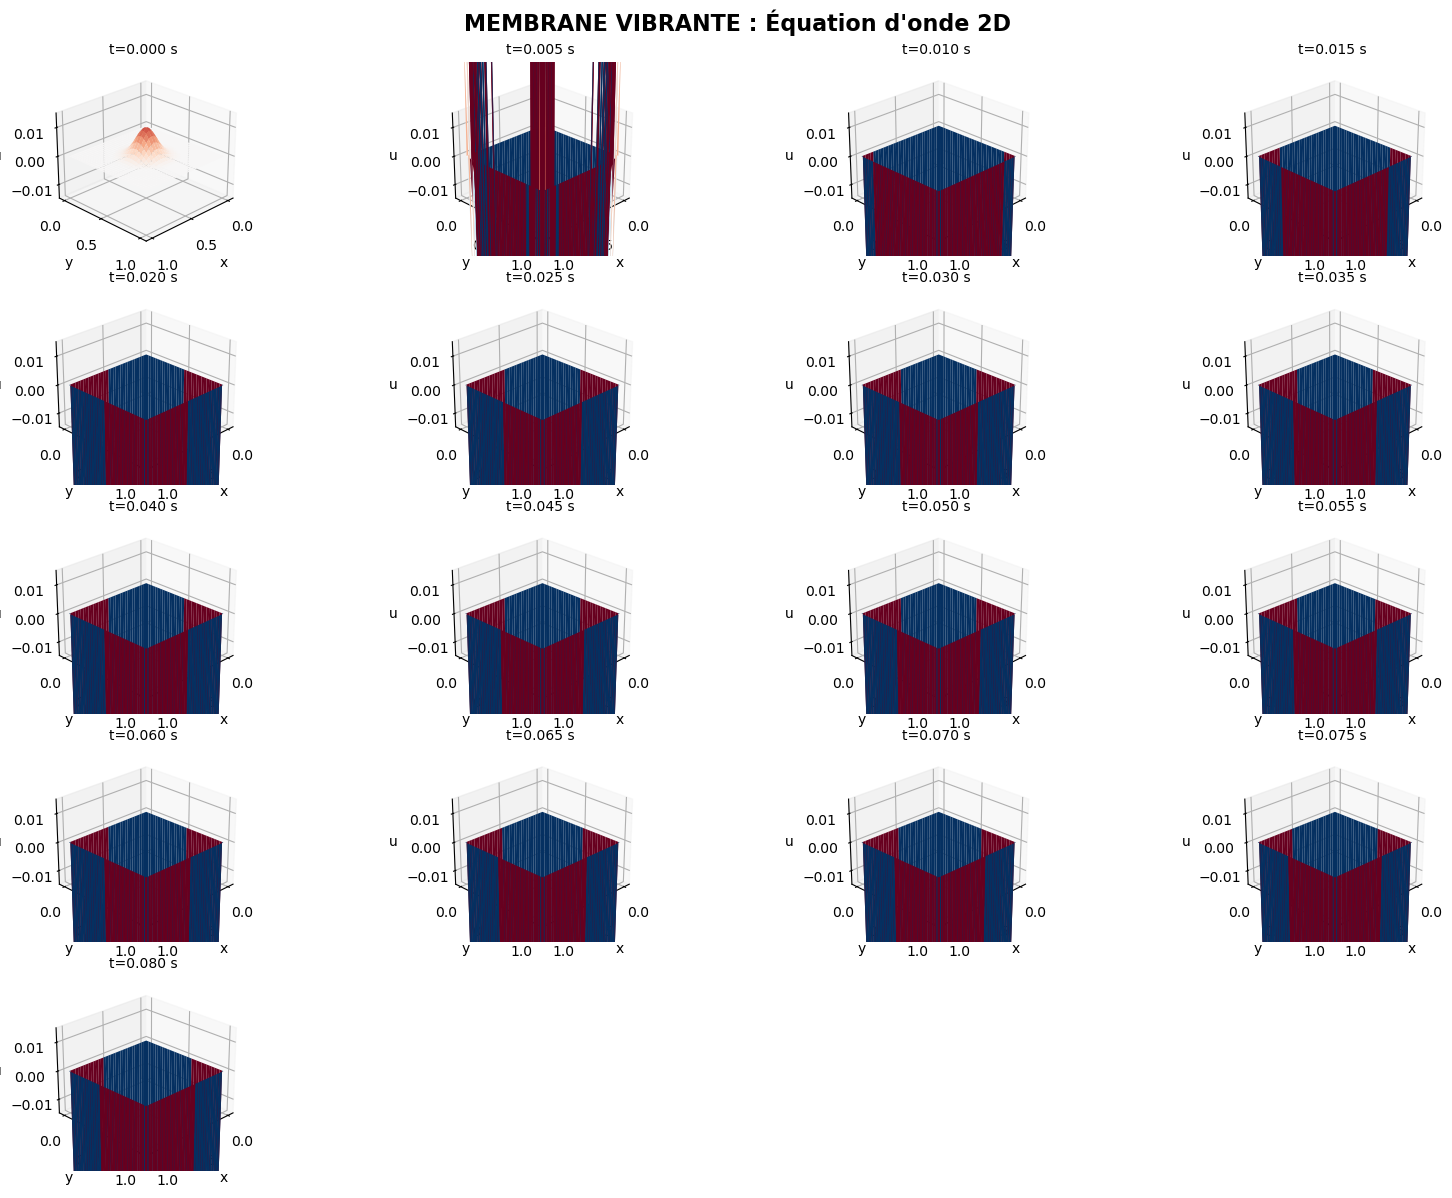

✓ Graphique sauvegardé : wave_2d_membrane_top.png


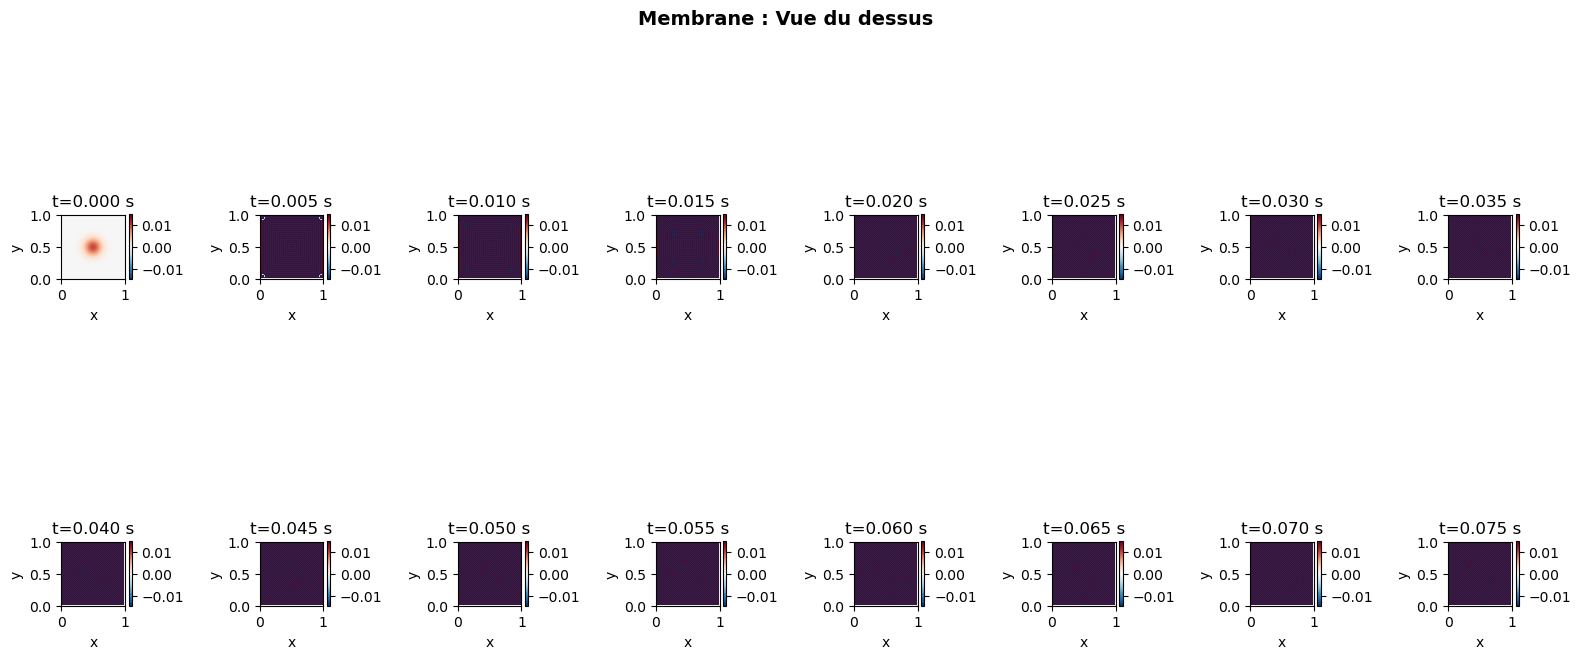


Simulation terminée !


(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 ]),
 array([[[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
           0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
         [ 0.00000000e+000,  6.62295965e-013,  1.41031792e-012, ...,
           1.41031792e-012,  6.62295965e-013,  0.00000000e+000],
         [ 0.00000000e+000,  1.41031792e-012,  3.00318398e-012, ...,
           3.00318398e-012,  1.41031792e-012,  0.00000000e+000],
         ...,
         [ 0.00000000e+000,  1.41031792e-012,  3.00318398e-012, ...,
           3.00318398e-012,  1.41031792e-012,  0.00000000e+000],
         [ 0.00000000e+000,  6.62295965e-013,  1.41031792e-012, ...,
           1.41031792e-012,  6.62295965e-013,  0.00000000e+000],
         [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
           0.00000000e+000,  0.00000000e+000,  0.00000000e+000]],
 
        [[ 0.00000000e+000,  0.00000000e+0

In [31]:
example_wave_2d_membrane()

In [32]:
def example_wave_damped():
    """
    Onde avec amortissement : ∂²_t u + γ∂_t u = c²∇²u
    
    Modèle :
    - Vibrations avec frottement
    - Amortissement visqueux
    - Dissipation d'énergie
    """
    print("="*60)
    print("ONDE AMORTIE : Dissipation d'énergie")
    print("="*60 + "\n")
    
    N = 512
    L = 1.0
    c = 100.0
    gamma = 5.0  # Coefficient d'amortissement
    
    grid = Grid.create_1d(N=N, L=L, periodic=False)
    solver = WaveEquationSolver(grid, bc_type='dirichlet', wave_speed=c)
    h_func = solver.create_wave_symbol()
    
    # Condition initiale
    x = grid.x
    u0 = 0.01 * np.sin(np.pi * x / L)  # Mode fondamental
    v0 = np.zeros_like(x)
    
    # Facteur de qualité Q = ω/γ où ω = πc/L
    omega = np.pi * c / L
    Q = omega / gamma
    
    # Temps de décroissance τ = 2/γ
    tau_decay = 2 / gamma
    
    print(f"Paramètres :")
    print(f"  c = {c} m/s")
    print(f"  γ = {gamma} s⁻¹")
    print(f"  Fréquence ω = {omega:.2f} rad/s")
    print(f"  Facteur de qualité Q = {Q:.2f}")
    print(f"  Temps de décroissance τ = {tau_decay:.4f} s")
    
    T_final = 5 * tau_decay
    Nt = 1000
    
    print(f"\nÉvolution sur {T_final/tau_decay:.1f}τ...")
    
    times, u_history, v_history = solver.evolve_wave(
        u0, v0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=20,
        damping=gamma
    )
    
    # Énergies
    energies = [WaveDiagnostics.total_energy(u, v, c, grid) 
               for u, v in zip(u_history, v_history)]
    
    # Ajustement exponentiel
    E_fit = energies[0] * np.exp(-gamma * times)
    
    print(f"\nÉnergie initiale : {energies[0]:.6e}")
    print(f"Énergie finale : {energies[-1]:.6e}")
    print(f"Décroissance : {(1 - energies[-1]/energies[0])*100:.1f}%")
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # (a) Évolution spatio-temporelle
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = ax1.imshow(u_history, aspect='auto', origin='lower',
                    extent=extent, cmap='RdBu_r')
    ax1.set_xlabel('Position x (m)', fontsize=12)
    ax1.set_ylabel('Temps t (s)', fontsize=12)
    ax1.set_title('Onde amortie : déplacement u(t,x)', fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('u (m)', fontsize=11)
    
    # (b) Oscillation au centre
    ax2 = fig.add_subplot(gs[1, 0])
    
    idx_center = N // 2
    u_center = [u[idx_center] for u in u_history]
    
    # Enveloppe exponentielle
    envelope = np.max(np.abs(u0)) * np.exp(-gamma * times / 2)
    
    ax2.plot(times, u_center, 'b-', linewidth=1.5, label='u(L/2, t)')
    ax2.plot(times, envelope, 'r--', linewidth=2, label='Enveloppe exp(-γt/2)')
    ax2.plot(times, -envelope, 'r--', linewidth=2)
    ax2.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax2.set_xlabel('Temps t (s)', fontsize=11)
    ax2.set_ylabel('u(x=L/2, t)', fontsize=11)
    ax2.set_title('Oscillation amortie au centre', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # (c) Décroissance d'énergie
    ax3 = fig.add_subplot(gs[1, 1])
    
    ax3.semilogy(times, energies, 'b-', linewidth=2, label='E(t) mesurée')
    ax3.semilogy(times, E_fit, 'r--', linewidth=2, label='E₀ exp(-γt)')
    
    ax3.set_xlabel('Temps t (s)', fontsize=11)
    ax3.set_ylabel('Énergie E (échelle log)', fontsize=11)
    ax3.set_title('Décroissance exponentielle de l\'énergie', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3, which='both')
    
    # (d) Énergie normalisée
    ax4 = fig.add_subplot(gs[2, 0])
    
    E_norm = np.array(energies) / energies[0]
    E_fit_norm = E_fit / energies[0]
    
    ax4.plot(times, E_norm, 'b-', linewidth=2, label='Mesurée')
    ax4.plot(times, E_fit_norm, 'r--', linewidth=2, label='Théorie')
    
    # Marquer τ
    ax4.axvline(tau_decay, color='g', linestyle=':', linewidth=2, 
               label=f'τ = {tau_decay:.3f} s')
    ax4.axhline(np.exp(-1), color='g', linestyle=':', linewidth=1, alpha=0.5)
    
    ax4.set_xlabel('Temps t (s)', fontsize=11)
    ax4.set_ylabel('E(t) / E₀', fontsize=11)
    ax4.set_title('Énergie normalisée', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([0, 1.1])
    
    # (e) Comparaison : amorti vs non amorti
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Simuler sans amortissement pour comparaison
    print("\n  Simulation de référence (sans amortissement)...")
    times_ref, u_history_ref, v_history_ref = solver.evolve_wave(
        u0, v0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=20,
        damping=0.0
    )
    
    u_center_ref = [u[idx_center] for u in u_history_ref]
    
    ax5.plot(times, u_center, 'b-', linewidth=2, label=f'Amorti (γ={gamma})')
    ax5.plot(times_ref, u_center_ref, 'r--', linewidth=2, alpha=0.7, 
            label='Non amorti (γ=0)')
    ax5.axhline(0, color='k', linestyle='-', linewidth=0.5)
    
    ax5.set_xlabel('Temps t (s)', fontsize=11)
    ax5.set_ylabel('u(x=L/2, t)', fontsize=11)
    ax5.set_title('Comparaison amorti / non amorti', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle(f'ONDE AMORTIE : Dissipation avec γ={gamma} s⁻¹ (Q={Q:.1f})', 
                 fontsize=16, fontweight='bold')
    
    filename = 'wave_damped.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Simulation terminée !")
    print("="*60)
    
    return times, u_history, v_history, grid

ONDE AMORTIE : Dissipation d'énergie

Paramètres :
  c = 100.0 m/s
  γ = 5.0 s⁻¹
  Fréquence ω = 314.16 rad/s
  Facteur de qualité Q = 62.83
  Temps de décroissance τ = 0.4000 s

Évolution sur 5.0τ...
Résolution équation d'onde : t=0.0 → 2.0
  Vitesse c = 100.0
  Amortissement γ = 5.0


/home/fifi/psipy/src/psinumpy.py:2302: RuntimeWarning: overflow encountered in multiply
  v_k = v_k + (dt / 2) * (self.c**2 * laplacian * u_k)
/home/fifi/psipy/src/psinumpy.py:2293: RuntimeWarning: overflow encountered in multiply
  v_k = v_k + (dt / 2) * (self.c**2 * laplacian * u_k)


  t=0.2000 (100/1000), E_cin=nan, E_pot=nan
  t=0.4000 (200/1000), E_cin=nan, E_pot=nan
  t=0.6000 (300/1000), E_cin=nan, E_pot=nan
  t=0.8000 (400/1000), E_cin=nan, E_pot=nan
  t=1.0000 (500/1000), E_cin=nan, E_pot=nan
  t=1.2000 (600/1000), E_cin=nan, E_pot=nan
  t=1.4000 (700/1000), E_cin=nan, E_pot=nan
  t=1.6000 (800/1000), E_cin=nan, E_pot=nan
  t=1.8000 (900/1000), E_cin=nan, E_pot=nan
  t=2.0000 (1000/1000), E_cin=nan, E_pot=nan
✓ Résolution terminée

Énergie initiale : 5.076567e+10
Énergie finale : nan
Décroissance : nan%

  Simulation de référence (sans amortissement)...
Résolution équation d'onde : t=0.0 → 2.0
  Vitesse c = 100.0


/home/fifi/psipy/src/psinumpy.py:2365: RuntimeWarning: overflow encountered in square
  E_kin = 0.5 * np.trapz(v**2, grid.x)
/home/fifi/psipy/src/psinumpy.py:2369: RuntimeWarning: overflow encountered in square
  E_pot = 0.5 * c**2 * np.sum(grid.xi**2 * np.abs(u_k)**2) * grid.dxi


  t=0.2000 (100/1000), E_cin=nan, E_pot=nan
  t=0.4000 (200/1000), E_cin=nan, E_pot=nan
  t=0.6000 (300/1000), E_cin=nan, E_pot=nan
  t=0.8000 (400/1000), E_cin=nan, E_pot=nan
  t=1.0000 (500/1000), E_cin=nan, E_pot=nan
  t=1.2000 (600/1000), E_cin=nan, E_pot=nan
  t=1.4000 (700/1000), E_cin=nan, E_pot=nan
  t=1.6000 (800/1000), E_cin=nan, E_pot=nan
  t=1.8000 (900/1000), E_cin=nan, E_pot=nan
  t=2.0000 (1000/1000), E_cin=nan, E_pot=nan
✓ Résolution terminée

✓ Graphique sauvegardé : wave_damped.png


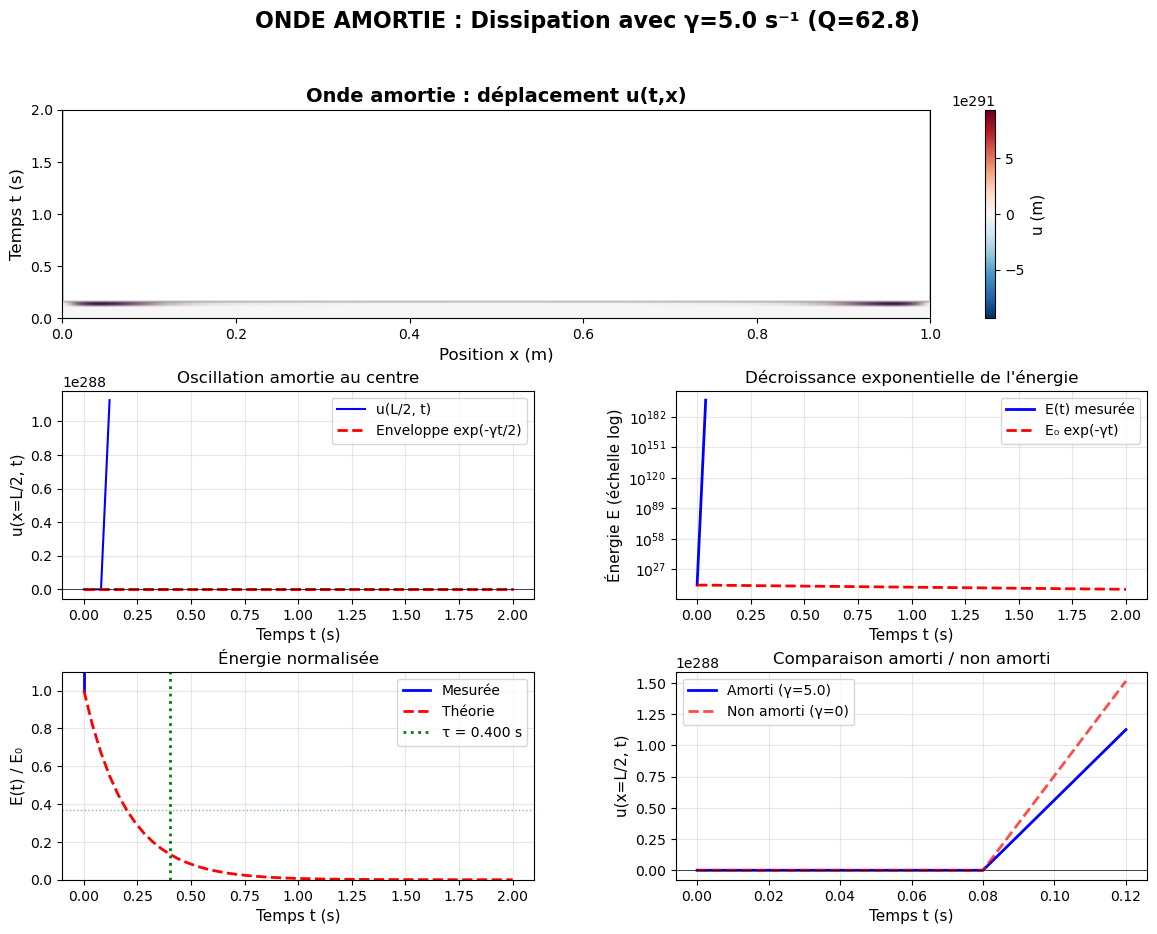


Simulation terminée !


(array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 array([[ 0.00000000e+000,  6.14789210e-005,  1.22955518e-004, ...,
          1.22955518e-004,  6.14789210e-005,  1.22464680e-018],
        [ 0.00000000e+000,  6.43163371e+091, -1.04365331e+092, ...,
         -1.04365331e+092,  6.43163371e+091,  0.00000000e+000],
        [ 0.00000000e+000,  1.90332367e+191, -3.13539379e+191, ...,
         -3.13539379e+191,  1.90332367e+191,  0.00000000e+000],
        ...,
        [ 0.00000000e+000,              nan,              nan, ...,
                      nan,              nan,  0.00000000e+000],
        [ 0.00000000e+000,              nan,              nan, ...,
                      nan,              nan

In [33]:
example_wave_damped()

In [34]:
def example_dispersive_wave():
    """
    Paquet d'onde dans milieu dispersif
    
    Observation de l'étalement du paquet dû à la dispersion
    """
    print("="*60)
    print("ONDE DISPERSIVE : Paquet d'onde s'étalant")
    print("="*60 + "\n")
    
    N = 512
    L = 50.0
    c = 10.0
    alpha = 0.5  # Coefficient de dispersion
    
    grid = Grid.create_1d(N=N, L=L, periodic=True)
    solver = DispersiveWaveSolver(grid, 'periodic', c, alpha)
    h_func = solver.create_dispersive_symbol()
    
    # Paquet d'onde : onde modulée par gaussienne
    x = grid.x
    x0 = L / 2
    sigma = 2.0
    k0 = 2.0  # Nombre d'onde central
    
    u0 = np.exp(-(x - x0)**2 / (2*sigma**2)) * np.cos(k0 * (x - x0))
    v0 = np.zeros_like(x)
    
    # Vitesse de groupe au nombre d'onde k0
    v_g_k0 = solver.group_velocity(np.array([k0]))[0]
    
    # Largeur théorique après temps t : σ(t) ≈ σ₀√(1 + (v_g' t / σ₀)²)
    # où v_g' = dv_g/dξ (dispersion de la vitesse de groupe)
    
    print(f"Paramètres :")
    print(f"  c = {c}, α = {alpha}")
    print(f"  Paquet : x₀ = {x0}, σ₀ = {sigma}, k₀ = {k0}")
    print(f"  Vitesse de groupe v_g(k₀) = {v_g_k0:.3f}")
    
    T_final = 3.0
    Nt = 600
    
    print(f"\nÉvolution...")
    
    times, u_history, v_history = solver.evolve_wave(
        u0, v0, h_func,
        t_span=(0.0, T_final),
        Nt=Nt,
        save_every=15
    )
    
    # Mesurer l'étalement
    widths = []
    positions = []
    
    for u in u_history:
        # Enveloppe (valeur absolue du signal analytique)
        from scipy.signal import hilbert
        envelope = np.abs(hilbert(u))
        
        # Centre du paquet
        x_center = np.sum(x * envelope) / np.sum(envelope)
        positions.append(x_center)
        
        # Largeur
        variance = np.sum((x - x_center)**2 * envelope) / np.sum(envelope)
        widths.append(np.sqrt(variance))
    
    print(f"\nRésultats :")
    print(f"  Largeur initiale : σ₀ = {widths[0]:.3f}")
    print(f"  Largeur finale : σ(T) = {widths[-1]:.3f}")
    print(f"  Étalement : {widths[-1]/widths[0]:.2f}×")
    print(f"  Position initiale : {positions[0]:.2f}")
    print(f"  Position finale : {positions[-1]:.2f}")
    print(f"  Déplacement : {positions[-1] - positions[0]:.2f}")
    print(f"  Vitesse moyenne : {(positions[-1] - positions[0])/T_final:.3f}")
    print(f"  v_g théorique : {v_g_k0:.3f}")
    
    # Visualisation
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # (a) Évolution spatio-temporelle
    ax1 = fig.add_subplot(gs[0, :])
    
    extent = [grid.x[0], grid.x[-1], times[0], times[-1]]
    im = ax1.imshow(u_history, aspect='auto', origin='lower',
                    extent=extent, cmap='RdBu_r')
    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Temps t', fontsize=12)
    ax1.set_title('Paquet d\'onde dispersif', fontsize=14, fontweight='bold')
    
    # Trajectoire du centre
    ax1.plot(positions, times, 'y-', linewidth=2, label='Centre du paquet')
    
    # Vitesse de groupe théorique
    x_theory = (x0 + v_g_k0 * times) % L
    ax1.plot(x_theory, times, 'c--', linewidth=2, alpha=0.7, 
            label=f'v_g(k₀)={v_g_k0:.2f}')
    
    ax1.legend(loc='upper left')
    
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('u', fontsize=11)
    
    # (b) Profils à différents temps
    ax2 = fig.add_subplot(gs[1, 0])
    
    indices = [0, len(times)//3, 2*len(times)//3, -1]
    colors = ['blue', 'green', 'orange', 'red']
    labels = ['t=0', f't={times[len(times)//3]:.2f}', 
             f't={times[2*len(times)//3]:.2f}', f't={times[-1]:.2f}']
    
    for idx, color, label in zip(indices, colors, labels):
        ax2.plot(grid.x, u_history[idx], color=color, linewidth=2, 
                label=label, alpha=0.7)
    
    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('u(x)', fontsize=11)
    ax2.set_title('Étalement du paquet', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # (c) Largeur vs temps
    ax3 = fig.add_subplot(gs[1, 1])
    
    ax3.plot(times, widths, 'b-', linewidth=2)
    ax3.axhline(widths[0], color='r', linestyle='--', linewidth=1, 
               label=f'σ₀ = {widths[0]:.2f}')
    
    ax3.set_xlabel('Temps t', fontsize=11)
    ax3.set_ylabel('Largeur σ(t)', fontsize=11)
    ax3.set_title('Étalement du paquet par dispersion', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # (d) Position du centre vs temps
    ax4 = fig.add_subplot(gs[2, 0])
    
    ax4.plot(times, positions, 'b-', linewidth=2, label='Mesuré')
    ax4.plot(times, x0 + v_g_k0 * times, 'r--', linewidth=2, 
            label=f'Théorie (v_g={v_g_k0:.2f})')
    
    ax4.set_xlabel('Temps t', fontsize=11)
    ax4.set_ylabel('Position du centre x_c(t)', fontsize=11)
    ax4.set_title('Propagation du centre du paquet', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # (e) Relation de dispersion
    ax5 = fig.add_subplot(gs[2, 1])
    
    xi_range = np.linspace(-10, 10, 200)
    omega_range = np.sqrt(c**2 * xi_range**2 + alpha * xi_range**4)
    v_g_range = solver.group_velocity(xi_range)
    
    ax5_twin = ax5.twinx()
    
    line1 = ax5.plot(xi_range, omega_range, 'b-', linewidth=2, 
                    label='ω(ξ)')
    ax5.axvline(k0, color='r', linestyle=':', linewidth=1, alpha=0.5)
    
    line2 = ax5_twin.plot(xi_range, v_g_range, 'g--', linewidth=2, 
                         label='v_g(ξ)')
    
    ax5.set_xlabel('Nombre d\'onde ξ', fontsize=11)
    ax5.set_ylabel('Fréquence ω', fontsize=11, color='b')
    ax5_twin.set_ylabel('Vitesse de groupe v_g', fontsize=11, color='g')
    ax5.set_title('Relation de dispersion', fontsize=12)
    
    # Légende combinée
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax5.legend(lines, labels, loc='upper left')
    
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='y', labelcolor='b')
    ax5_twin.tick_params(axis='y', labelcolor='g')
    
    plt.suptitle(f'ONDE DISPERSIVE : α={alpha} (étalement {widths[-1]/widths[0]:.2f}×)', 
                 fontsize=16, fontweight='bold')
    
    filename = 'wave_dispersive.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Graphique sauvegardé : {filename}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("Le paquet d'onde s'étale à cause de la dispersion !")
    print("="*60)
    
    return times, u_history, v_history, grid

ONDE DISPERSIVE : Paquet d'onde s'étalant

Paramètres :
  c = 10.0, α = 0.5
  Paquet : x₀ = 25.0, σ₀ = 2.0, k₀ = 2.0
  Vitesse de groupe v_g(k₀) = 10.298

Évolution...
Résolution équation d'onde : t=0.0 → 3.0
  Vitesse c = 10.0
  t=0.3000 (60/600), E_cin=4.5092e+108, E_pot=2.4140e+102
  t=0.6000 (120/600), E_cin=2.6730e+245, E_pot=1.4085e+239
  t=0.9000 (180/600), E_cin=inf, E_pot=inf
  t=1.2000 (240/600), E_cin=inf, E_pot=inf


/home/fifi/psipy/src/psinumpy.py:2302: RuntimeWarning: invalid value encountered in multiply
  v_k = v_k + (dt / 2) * (self.c**2 * laplacian * u_k)
/home/fifi/psipy/src/psinumpy.py:2293: RuntimeWarning: invalid value encountered in multiply
  v_k = v_k + (dt / 2) * (self.c**2 * laplacian * u_k)


  t=1.5000 (300/600), E_cin=nan, E_pot=nan
  t=1.8000 (360/600), E_cin=nan, E_pot=nan
  t=2.1000 (420/600), E_cin=nan, E_pot=nan
  t=2.4000 (480/600), E_cin=nan, E_pot=nan
  t=2.7000 (540/600), E_cin=nan, E_pot=nan
  t=3.0000 (600/600), E_cin=nan, E_pot=nan
✓ Résolution terminée

Résultats :
  Largeur initiale : σ₀ = 2.005
  Largeur finale : σ(T) = nan
  Étalement : nan×
  Position initiale : 25.00
  Position finale : nan
  Déplacement : nan
  Vitesse moyenne : nan
  v_g théorique : 10.298

✓ Graphique sauvegardé : wave_dispersive.png


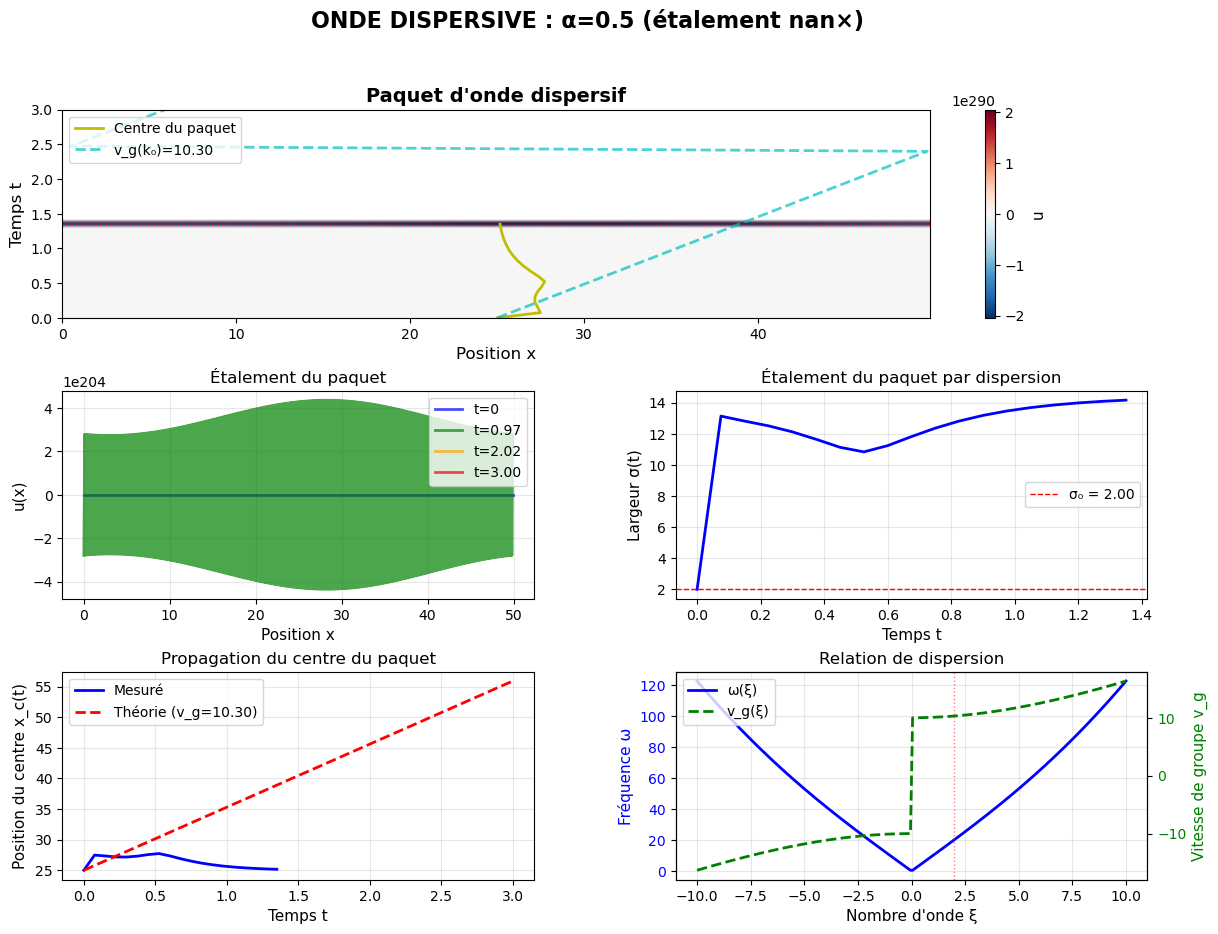


Le paquet d'onde s'étale à cause de la dispersion !


(array([0.   , 0.075, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
        0.675, 0.75 , 0.825, 0.9  , 0.975, 1.05 , 1.125, 1.2  , 1.275,
        1.35 , 1.425, 1.5  , 1.575, 1.65 , 1.725, 1.8  , 1.875, 1.95 ,
        2.025, 2.1  , 2.175, 2.25 , 2.325, 2.4  , 2.475, 2.55 , 2.625,
        2.7  , 2.775, 2.85 , 2.925, 3.   ]),
 array([[ 1.13567908e-34,  1.93847601e-34,  3.14591459e-34, ...,
          4.78774406e-34,  3.14591459e-34,  1.93847601e-34],
        [ 3.02324485e-01, -2.98629428e-01,  2.93481899e-01, ...,
         -3.04654021e-01,  3.05274250e-01, -3.04529444e-01],
        [-2.35763575e+16,  2.34763247e+16, -2.33602462e+16, ...,
          2.37753638e+16, -2.37262795e+16,  2.36598233e+16],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,   

In [35]:
example_dispersive_wave()

In [3]:
benchmark_performance()


BENCHMARKS DE PERFORMANCE

Benchmarks 1D :
------------------------------------------------------------
Taille     Symbole      Moyal        Inverse      Évolution (10 pas)  
------------------------------------------------------------
Décomposition T+V imprécise (erreur: 5.03e+00), utilisation de la méthode générale
32             0.60 ms      1.25 ms      4.61 ms             6.86 ms
Décomposition T+V imprécise (erreur: 1.01e+01), utilisation de la méthode générale
64             0.15 ms      1.47 ms      7.26 ms             4.41 ms
Décomposition T+V imprécise (erreur: 2.01e+01), utilisation de la méthode générale
128            0.36 ms      4.58 ms     26.90 ms             8.12 ms
Décomposition T+V imprécise (erreur: 4.02e+01), utilisation de la méthode générale
256            3.67 ms     19.95 ms    152.83 ms            25.17 ms
Décomposition T+V imprécise (erreur: 8.04e+01), utilisation de la méthode générale
512           13.95 ms     83.26 ms    503.18 ms            70.41 ms


B

{'1D': {32: {'symbol': 0.5998611450195312,
   'moyal': 1.2466907501220703,
   'inverse': 4.607915878295898,
   'evolution': 6.862163543701172},
  64: {'symbol': 0.15425682067871094,
   'moyal': 1.4715194702148438,
   'inverse': 7.26318359375,
   'evolution': 4.414558410644531},
  128: {'symbol': 0.35643577575683594,
   'moyal': 4.58216667175293,
   'inverse': 26.897668838500977,
   'evolution': 8.117914199829102},
  256: {'symbol': 3.669261932373047,
   'moyal': 19.94943618774414,
   'inverse': 152.82654762268066,
   'evolution': 25.17247200012207},
  512: {'symbol': 13.945817947387695,
   'moyal': 83.25624465942383,
   'inverse': 503.17978858947754,
   'evolution': 70.40739059448242}},
 '2D': {16: {'symbol': 0.7266998291015625,
   'moyal': 3.8688182830810547,
   'evolution': 10.240316390991211},
  32: {'symbol': 9.307622909545898,
   'moyal': 147.4597454071045,
   'evolution': 447.268009185791},
  64: {'symbol': 147.2792625427246,
   'moyal': 4937.9563331604,
   'evolution': 4813.4918